
## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## Perform a HOG feature extraction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

MY_Y_START_STOP = [400, 656]
COLOR_SPACE_CONST = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
ORIENT_CONST = 9  # HOG orientations
PIX_PER_CELL_CONST = 8 # HOG pixels per cell
CELL_PER_BLOCK_CONST = 2 # HOG cells per block
HOG_CHANNEL_CONST = 'ALL' # Can be 0, 1, 2, or "ALL"
SPATIAL_SIZE_CONST = (32, 32) # Spatial binning dimensions
HIST_BINS_CONST = 32    # Number of histogram bins
SPATIAL_BINS_CONST = True # Spatial features on or off
SPATIAL_FEAT_CONST = True
HIST_FEAT_CONST = True # Histogram features on or off
HOG_FEAT_CONST = True # HOG features on or off
XY_WINDOW_CONST=(96, 96)
XY_OVERLAP_CONST=(0.5, 0.5)

In [2]:
def get_hog_features(img, orient=ORIENT_CONST, pix_per_cell=PIX_PER_CELL_CONST, cell_per_block=CELL_PER_BLOCK_CONST, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=SPATIAL_SIZE_CONST):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=HIST_BINS_CONST):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

features shape:  (1764,)


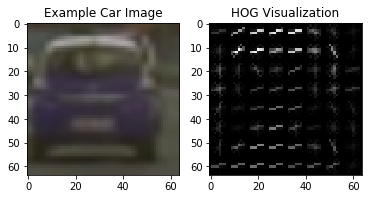

In [4]:
# Test
test_image = './vehicles/GTI_MiddleClose/image0050.png'

image = cv2.imread(test_image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, vis=True)

print("features shape: ", features.shape)
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image,cmap='gray')
plt.title('HOG Visualization')
plt.show()

## SVM Train and Classify

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space=COLOR_SPACE_CONST, spatial_size=SPATIAL_SIZE_CONST,
                        hist_bins=HIST_BINS_CONST, orient=ORIENT_CONST, 
                        pix_per_cell=PIX_PER_CELL_CONST, cell_per_block=CELL_PER_BLOCK_CONST, hog_channel=HOG_CHANNEL_CONST,
                        spatial_feat=SPATIAL_FEAT_CONST, hist_feat=HIST_FEAT_CONST, hog_feat=HOG_FEAT_CONST):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



# Divide up into cars and notcars
car_images = glob.glob('./vehicles/*/*.png')
noncar_images = glob.glob('./non-vehicles/*/*.png')

cars = []
notcars = []

for x in car_images:
    cars.append(x)

for x in noncar_images:
    notcars.append(x)
    

print("cars= {0}".format(len(cars)))
print("notcars= {0}".format(len(notcars)))

t=time.time()

car_features = extract_features(cars)
notcar_features = extract_features(notcars)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

cars= 8792
notcars= 8968
67.04 Seconds to extract HOG features...


In [6]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [7]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Feature vector length: 8460
3.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


In [8]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts is : ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts is :  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00214 Seconds to predict 10 labels with SVC


## Sliding Window

In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=XY_WINDOW_CONST, xy_overlap=XY_OVERLAP_CONST):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

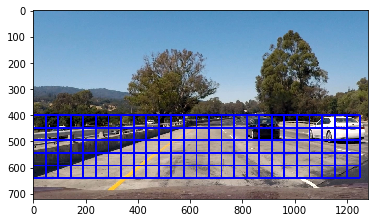

In [10]:
# test sliding window

test_image = './test_images/test1.jpg'

image = cv2.imread(test_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=MY_Y_START_STOP, 
                    xy_window=XY_WINDOW_CONST, xy_overlap=XY_OVERLAP_CONST)
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()


In [11]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features ()
# just for a single image rather than list of images
def single_img_features(img, color_space=COLOR_SPACE_CONST, spatial_size=SPATIAL_SIZE_CONST,
                        hist_bins=HIST_BINS_CONST, orient=ORIENT_CONST, 
                        pix_per_cell=PIX_PER_CELL_CONST, cell_per_block=CELL_PER_BLOCK_CONST, hog_channel=HOG_CHANNEL_CONST,
                        spatial_feat=SPATIAL_FEAT_CONST, hist_feat=HIST_FEAT_CONST, hog_feat=HOG_FEAT_CONST):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=SPATIAL_SIZE_CONST, hist_bins=HIST_BINS_CONST, 
                    hist_range=(0, 256), orient=ORIENT_CONST, 
                    pix_per_cell=PIX_PER_CELL_CONST, cell_per_block=CELL_PER_BLOCK_CONST, 
                    hog_channel=HOG_CHANNEL_CONST, spatial_feat=SPATIAL_FEAT_CONST, 
                    hist_feat=HIST_FEAT_CONST, hog_feat=HOG_FEAT_CONST):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

Result for single patch extraction ..
6


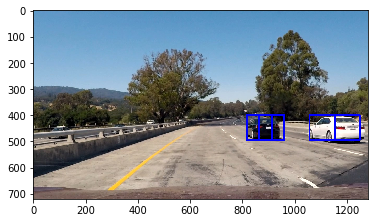

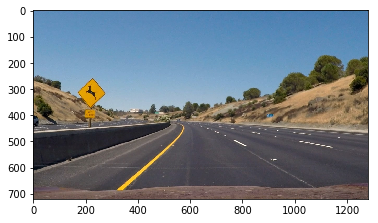

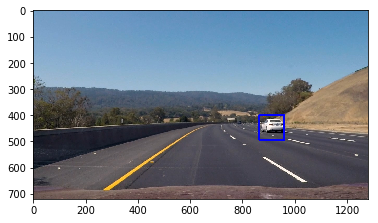

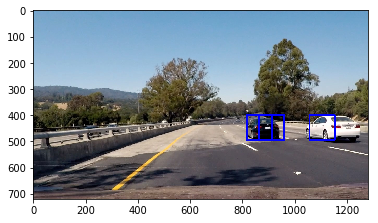

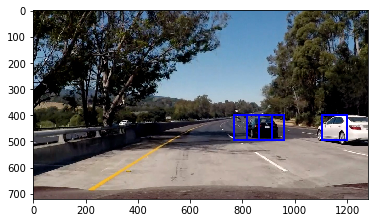

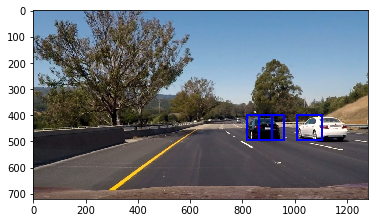

In [12]:
# test single patch

print("Result for single patch extraction ..")
test_images = glob.glob('./test_images/*.jpg')
print(len(test_images))

for test_image in test_images:
    image = cv2.imread(test_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = image.astype(np.float32)/255.0
    draw_image = np.copy(image)

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=MY_Y_START_STOP, 
                    xy_window=XY_WINDOW_CONST, xy_overlap=XY_OVERLAP_CONST)
   
    hot_windows = search_windows(image, windows, svc, X_scaler)   

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    plt.show()

In [13]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a single function that can extract features using hog sub-sampling and make predictions

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    # don't do this for YCrCb color scheme img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for t his patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    print("Count windows = ", count)
    return draw_img, bbox_list 

Results for hog subsampling..
6
Count windows =  294


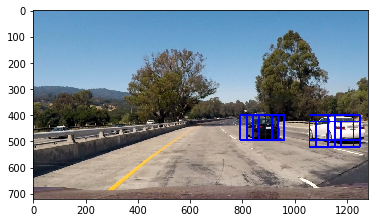

Count windows =  294


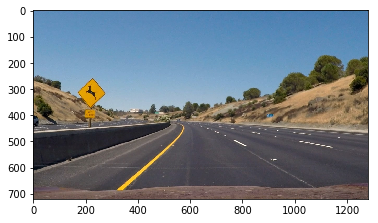

Count windows =  294


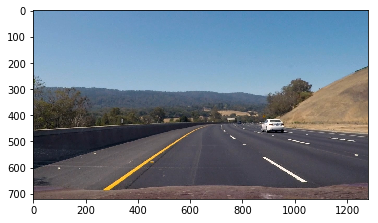

Count windows =  294


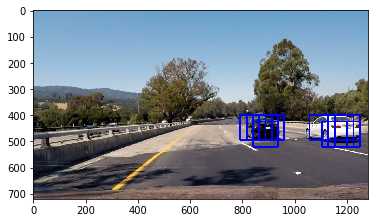

Count windows =  294


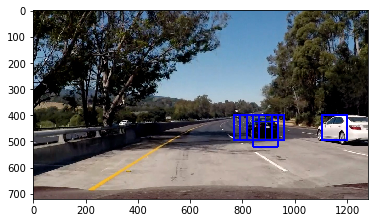

Count windows =  294


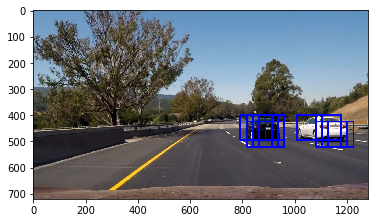

In [14]:
# find_cars hog_subsample test

print("Results for hog subsampling..")
ystart = 400
ystop = 656
scale = 1.5

test_images = glob.glob('./test_images/*.jpg')
print(len(test_images))

for test_image in test_images:
    image = cv2.imread(test_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    out_img, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient=ORIENT_CONST, pix_per_cell=PIX_PER_CELL_CONST, cell_per_block=CELL_PER_BLOCK_CONST, 
                    hist_bins=HIST_BINS_CONST, spatial_size=SPATIAL_SIZE_CONST)
    plt.imshow(out_img)
    plt.show()

## +ve detection and removal

In [15]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [16]:
def gen_thresholded_heat_map(box_list, threshold):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    heat = add_heat(heat, box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    
    return heat
    

Count windows =  294


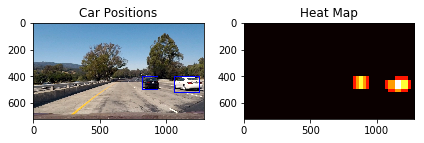

Count windows =  294


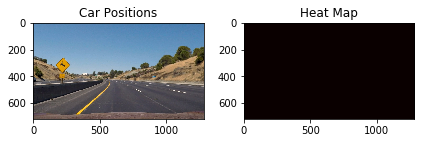

Count windows =  294


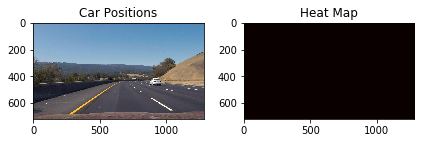

Count windows =  294


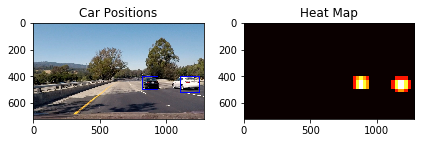

Count windows =  294


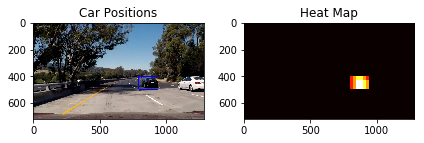

Count windows =  294


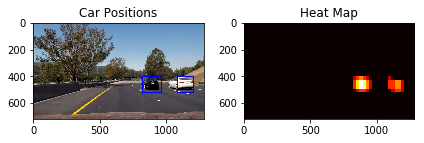

In [17]:
# test +ve detection.
# Add heat to each box in box list

test_images = glob.glob('./test_images/*.jpg')

for test_image in test_images:
    image = cv2.imread(test_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient=ORIENT_CONST, pix_per_cell=PIX_PER_CELL_CONST, 
                                  cell_per_block=CELL_PER_BLOCK_CONST, hist_bins=HIST_BINS_CONST, spatial_size=SPATIAL_SIZE_CONST)
    
    #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=MY_Y_START_STOP, xy_window=(96, 96), xy_overlap=(0.75, 0.75))
   
    #box_list = search_windows(image, windows, svc, X_scaler) 

    heat = gen_thresholded_heat_map(box_list, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

## Tracking pipeline

In [18]:
def pipeline(image):
    out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient=ORIENT_CONST, pix_per_cell=PIX_PER_CELL_CONST, 
             cell_per_block=CELL_PER_BLOCK_CONST, hist_bins=HIST_BINS_CONST, spatial_size=SPATIAL_SIZE_CONST)
    

    heat = gen_thresholded_heat_map(box_list, 1)
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

Count windows =  294


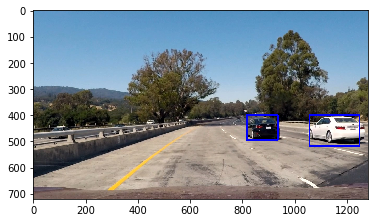

Count windows =  294


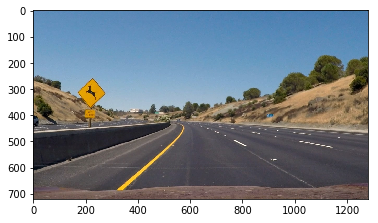

Count windows =  294


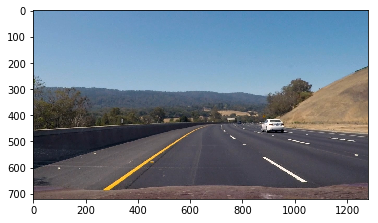

Count windows =  294


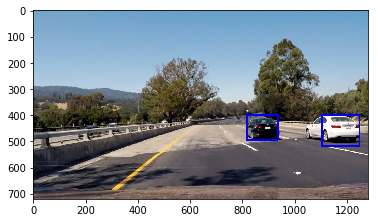

Count windows =  294


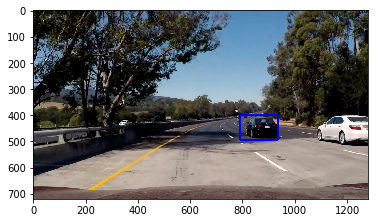

Count windows =  294


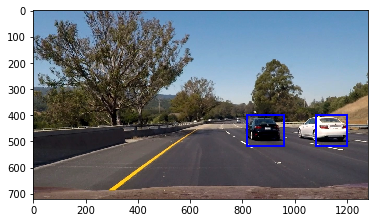

In [19]:
# test pipeline.
test_images = glob.glob('./test_images/*.jpg')

for test_image in test_images:
    image = cv2.imread(test_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    draw_img = pipeline(image)

    plt.imshow(draw_img)
    plt.show()

## Generate Video

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image):
    draw_image = pipeline(image)
    return draw_image

In [22]:
output = 'project_video_soln.mp4'
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

Count windows =  294
[MoviePy] >>>> Building video project_video_soln.mp4
[MoviePy] Writing video project_video_soln.mp4


  0%|          | 1/1261 [00:00<06:33,  3.20it/s]

Count windows =  294


  0%|          | 2/1261 [00:00<06:33,  3.20it/s]

Count windows =  294


  0%|          | 3/1261 [00:00<06:34,  3.19it/s]

Count windows =  294


  0%|          | 4/1261 [00:01<06:32,  3.21it/s]

Count windows =  294


  0%|          | 5/1261 [00:01<06:29,  3.23it/s]

Count windows =  294


  0%|          | 6/1261 [00:01<06:27,  3.24it/s]

Count windows =  294


  1%|          | 7/1261 [00:02<06:26,  3.25it/s]

Count windows =  294


  1%|          | 8/1261 [00:02<06:27,  3.24it/s]

Count windows =  294


  1%|          | 9/1261 [00:02<06:25,  3.25it/s]

Count windows =  294


  1%|          | 10/1261 [00:03<06:23,  3.26it/s]

Count windows =  294


  1%|          | 11/1261 [00:03<06:26,  3.24it/s]

Count windows =  294


  1%|          | 12/1261 [00:03<06:25,  3.24it/s]

Count windows =  294


  1%|          | 13/1261 [00:04<06:25,  3.24it/s]

Count windows =  294


  1%|          | 14/1261 [00:04<06:23,  3.25it/s]

Count windows =  294


  1%|          | 15/1261 [00:04<06:25,  3.23it/s]

Count windows =  294


  1%|▏         | 16/1261 [00:04<06:26,  3.22it/s]

Count windows =  294


  1%|▏         | 17/1261 [00:05<06:30,  3.19it/s]

Count windows =  294


  1%|▏         | 18/1261 [00:05<06:28,  3.20it/s]

Count windows =  294


  2%|▏         | 19/1261 [00:05<06:27,  3.20it/s]

Count windows =  294


  2%|▏         | 20/1261 [00:06<06:27,  3.20it/s]

Count windows =  294


  2%|▏         | 21/1261 [00:06<06:27,  3.20it/s]

Count windows =  294


  2%|▏         | 22/1261 [00:06<06:27,  3.20it/s]

Count windows =  294


  2%|▏         | 23/1261 [00:07<06:28,  3.18it/s]

Count windows =  294


  2%|▏         | 24/1261 [00:07<06:25,  3.21it/s]

Count windows =  294


  2%|▏         | 25/1261 [00:07<06:26,  3.20it/s]

Count windows =  294


  2%|▏         | 26/1261 [00:08<06:25,  3.20it/s]

Count windows =  294


  2%|▏         | 27/1261 [00:08<06:22,  3.23it/s]

Count windows =  294


  2%|▏         | 28/1261 [00:08<06:20,  3.24it/s]

Count windows =  294


  2%|▏         | 29/1261 [00:08<06:18,  3.26it/s]

Count windows =  294


  2%|▏         | 30/1261 [00:09<06:20,  3.24it/s]

Count windows =  294


  2%|▏         | 31/1261 [00:09<06:20,  3.23it/s]

Count windows =  294


  3%|▎         | 32/1261 [00:09<06:20,  3.23it/s]

Count windows =  294


  3%|▎         | 33/1261 [00:10<06:18,  3.24it/s]

Count windows =  294


  3%|▎         | 34/1261 [00:10<06:15,  3.27it/s]

Count windows =  294


  3%|▎         | 35/1261 [00:10<06:16,  3.26it/s]

Count windows =  294


  3%|▎         | 36/1261 [00:11<06:17,  3.25it/s]

Count windows =  294


  3%|▎         | 37/1261 [00:11<06:16,  3.25it/s]

Count windows =  294


  3%|▎         | 38/1261 [00:11<06:16,  3.25it/s]

Count windows =  294


  3%|▎         | 39/1261 [00:12<06:15,  3.25it/s]

Count windows =  294


  3%|▎         | 40/1261 [00:12<06:20,  3.21it/s]

Count windows =  294


  3%|▎         | 41/1261 [00:12<06:20,  3.21it/s]

Count windows =  294


  3%|▎         | 42/1261 [00:13<06:16,  3.24it/s]

Count windows =  294


  3%|▎         | 43/1261 [00:13<06:19,  3.21it/s]

Count windows =  294


  3%|▎         | 44/1261 [00:13<06:18,  3.21it/s]

Count windows =  294


  4%|▎         | 45/1261 [00:13<06:16,  3.23it/s]

Count windows =  294


  4%|▎         | 46/1261 [00:14<06:19,  3.20it/s]

Count windows =  294


  4%|▎         | 47/1261 [00:14<06:21,  3.19it/s]

Count windows =  294


  4%|▍         | 48/1261 [00:14<06:19,  3.19it/s]

Count windows =  294


  4%|▍         | 49/1261 [00:15<06:19,  3.19it/s]

Count windows =  294


  4%|▍         | 50/1261 [00:15<06:18,  3.20it/s]

Count windows =  294


  4%|▍         | 51/1261 [00:15<06:19,  3.19it/s]

Count windows =  294


  4%|▍         | 52/1261 [00:16<06:22,  3.16it/s]

Count windows =  294


  4%|▍         | 53/1261 [00:16<06:27,  3.12it/s]

Count windows =  294


  4%|▍         | 54/1261 [00:16<06:27,  3.11it/s]

Count windows =  294


  4%|▍         | 55/1261 [00:17<06:25,  3.13it/s]

Count windows =  294


  4%|▍         | 56/1261 [00:17<06:22,  3.15it/s]

Count windows =  294


  5%|▍         | 57/1261 [00:17<06:22,  3.15it/s]

Count windows =  294


  5%|▍         | 58/1261 [00:18<06:16,  3.19it/s]

Count windows =  294


  5%|▍         | 59/1261 [00:18<06:16,  3.19it/s]

Count windows =  294


  5%|▍         | 60/1261 [00:18<06:13,  3.21it/s]

Count windows =  294


  5%|▍         | 61/1261 [00:18<06:15,  3.19it/s]

Count windows =  294


  5%|▍         | 62/1261 [00:19<06:14,  3.20it/s]

Count windows =  294


  5%|▍         | 63/1261 [00:19<06:12,  3.22it/s]

Count windows =  294


  5%|▌         | 64/1261 [00:19<06:12,  3.21it/s]

Count windows =  294


  5%|▌         | 65/1261 [00:20<06:15,  3.19it/s]

Count windows =  294


  5%|▌         | 66/1261 [00:20<06:14,  3.19it/s]

Count windows =  294


  5%|▌         | 67/1261 [00:20<06:14,  3.19it/s]

Count windows =  294


  5%|▌         | 68/1261 [00:21<06:13,  3.20it/s]

Count windows =  294


  5%|▌         | 69/1261 [00:21<06:14,  3.18it/s]

Count windows =  294


  6%|▌         | 70/1261 [00:21<06:10,  3.21it/s]

Count windows =  294


  6%|▌         | 71/1261 [00:22<06:10,  3.21it/s]

Count windows =  294


  6%|▌         | 72/1261 [00:22<06:09,  3.22it/s]

Count windows =  294


  6%|▌         | 73/1261 [00:22<06:08,  3.22it/s]

Count windows =  294


  6%|▌         | 74/1261 [00:23<06:08,  3.22it/s]

Count windows =  294


  6%|▌         | 75/1261 [00:23<06:15,  3.16it/s]

Count windows =  294


  6%|▌         | 76/1261 [00:23<06:14,  3.16it/s]

Count windows =  294


  6%|▌         | 77/1261 [00:24<06:12,  3.18it/s]

Count windows =  294


  6%|▌         | 78/1261 [00:24<06:08,  3.21it/s]

Count windows =  294


  6%|▋         | 79/1261 [00:24<06:06,  3.23it/s]

Count windows =  294


  6%|▋         | 80/1261 [00:24<06:03,  3.25it/s]

Count windows =  294


  6%|▋         | 81/1261 [00:25<06:04,  3.24it/s]

Count windows =  294


  7%|▋         | 82/1261 [00:25<06:04,  3.23it/s]

Count windows =  294


  7%|▋         | 83/1261 [00:25<06:04,  3.23it/s]

Count windows =  294


  7%|▋         | 84/1261 [00:26<06:02,  3.25it/s]

Count windows =  294


  7%|▋         | 85/1261 [00:26<06:02,  3.25it/s]

Count windows =  294


  7%|▋         | 86/1261 [00:26<06:03,  3.24it/s]

Count windows =  294


  7%|▋         | 87/1261 [00:27<06:02,  3.24it/s]

Count windows =  294


  7%|▋         | 88/1261 [00:27<06:04,  3.21it/s]

Count windows =  294


  7%|▋         | 89/1261 [00:27<06:03,  3.23it/s]

Count windows =  294


  7%|▋         | 90/1261 [00:28<06:03,  3.22it/s]

Count windows =  294


  7%|▋         | 91/1261 [00:28<06:03,  3.22it/s]

Count windows =  294


  7%|▋         | 92/1261 [00:28<06:01,  3.24it/s]

Count windows =  294


  7%|▋         | 93/1261 [00:28<06:02,  3.22it/s]

Count windows =  294


  7%|▋         | 94/1261 [00:29<06:02,  3.22it/s]

Count windows =  294


  8%|▊         | 95/1261 [00:29<06:02,  3.22it/s]

Count windows =  294


  8%|▊         | 96/1261 [00:29<06:01,  3.23it/s]

Count windows =  294


  8%|▊         | 97/1261 [00:30<06:02,  3.21it/s]

Count windows =  294


  8%|▊         | 98/1261 [00:30<06:02,  3.21it/s]

Count windows =  294


  8%|▊         | 99/1261 [00:30<06:02,  3.21it/s]

Count windows =  294


  8%|▊         | 100/1261 [00:31<06:02,  3.20it/s]

Count windows =  294


  8%|▊         | 101/1261 [00:31<06:01,  3.21it/s]

Count windows =  294


  8%|▊         | 102/1261 [00:31<06:00,  3.22it/s]

Count windows =  294


  8%|▊         | 103/1261 [00:32<05:59,  3.22it/s]

Count windows =  294


  8%|▊         | 104/1261 [00:32<05:57,  3.24it/s]

Count windows =  294


  8%|▊         | 105/1261 [00:32<05:57,  3.23it/s]

Count windows =  294


  8%|▊         | 106/1261 [00:32<05:58,  3.23it/s]

Count windows =  294


  8%|▊         | 107/1261 [00:33<05:56,  3.23it/s]

Count windows =  294


  9%|▊         | 108/1261 [00:33<05:57,  3.22it/s]

Count windows =  294


  9%|▊         | 109/1261 [00:33<05:57,  3.22it/s]

Count windows =  294


  9%|▊         | 110/1261 [00:34<05:58,  3.21it/s]

Count windows =  294


  9%|▉         | 111/1261 [00:34<05:58,  3.21it/s]

Count windows =  294


  9%|▉         | 112/1261 [00:34<05:58,  3.21it/s]

Count windows =  294


  9%|▉         | 113/1261 [00:35<05:55,  3.23it/s]

Count windows =  294


  9%|▉         | 114/1261 [00:35<05:55,  3.22it/s]

Count windows =  294


  9%|▉         | 115/1261 [00:35<05:54,  3.23it/s]

Count windows =  294


  9%|▉         | 116/1261 [00:36<05:54,  3.23it/s]

Count windows =  294


  9%|▉         | 117/1261 [00:36<05:53,  3.23it/s]

Count windows =  294


  9%|▉         | 118/1261 [00:36<05:53,  3.23it/s]

Count windows =  294


  9%|▉         | 119/1261 [00:37<05:53,  3.23it/s]

Count windows =  294


 10%|▉         | 120/1261 [00:37<05:51,  3.25it/s]

Count windows =  294


 10%|▉         | 121/1261 [00:37<05:48,  3.27it/s]

Count windows =  294


 10%|▉         | 122/1261 [00:37<05:52,  3.23it/s]

Count windows =  294


 10%|▉         | 123/1261 [00:38<05:51,  3.24it/s]

Count windows =  294


 10%|▉         | 124/1261 [00:38<05:50,  3.25it/s]

Count windows =  294


 10%|▉         | 125/1261 [00:38<05:49,  3.25it/s]

Count windows =  294


 10%|▉         | 126/1261 [00:39<05:51,  3.23it/s]

Count windows =  294


 10%|█         | 127/1261 [00:39<05:52,  3.22it/s]

Count windows =  294


 10%|█         | 128/1261 [00:39<05:51,  3.22it/s]

Count windows =  294


 10%|█         | 129/1261 [00:40<05:52,  3.22it/s]

Count windows =  294


 10%|█         | 130/1261 [00:40<05:51,  3.21it/s]

Count windows =  294


 10%|█         | 131/1261 [00:40<05:50,  3.22it/s]

Count windows =  294


 10%|█         | 132/1261 [00:41<05:50,  3.22it/s]

Count windows =  294


 11%|█         | 133/1261 [00:41<05:51,  3.21it/s]

Count windows =  294


 11%|█         | 134/1261 [00:41<05:51,  3.21it/s]

Count windows =  294


 11%|█         | 135/1261 [00:41<05:50,  3.21it/s]

Count windows =  294


 11%|█         | 136/1261 [00:42<05:47,  3.23it/s]

Count windows =  294


 11%|█         | 137/1261 [00:42<05:47,  3.24it/s]

Count windows =  294


 11%|█         | 138/1261 [00:42<05:45,  3.25it/s]

Count windows =  294


 11%|█         | 139/1261 [00:43<05:46,  3.24it/s]

Count windows =  294


 11%|█         | 140/1261 [00:43<05:48,  3.22it/s]

Count windows =  294


 11%|█         | 141/1261 [00:43<05:48,  3.21it/s]

Count windows =  294


 11%|█▏        | 142/1261 [00:44<05:49,  3.20it/s]

Count windows =  294


 11%|█▏        | 143/1261 [00:44<05:48,  3.21it/s]

Count windows =  294


 11%|█▏        | 144/1261 [00:44<05:46,  3.22it/s]

Count windows =  294


 11%|█▏        | 145/1261 [00:45<05:45,  3.23it/s]

Count windows =  294


 12%|█▏        | 146/1261 [00:45<05:46,  3.21it/s]

Count windows =  294


 12%|█▏        | 147/1261 [00:45<05:45,  3.22it/s]

Count windows =  294


 12%|█▏        | 148/1261 [00:46<05:44,  3.23it/s]

Count windows =  294


 12%|█▏        | 149/1261 [00:46<05:43,  3.23it/s]

Count windows =  294


 12%|█▏        | 150/1261 [00:46<05:44,  3.23it/s]

Count windows =  294


 12%|█▏        | 151/1261 [00:46<05:44,  3.23it/s]

Count windows =  294


 12%|█▏        | 152/1261 [00:47<05:43,  3.23it/s]

Count windows =  294


 12%|█▏        | 153/1261 [00:47<05:43,  3.23it/s]

Count windows =  294


 12%|█▏        | 154/1261 [00:47<05:42,  3.24it/s]

Count windows =  294


 12%|█▏        | 155/1261 [00:48<05:42,  3.23it/s]

Count windows =  294


 12%|█▏        | 156/1261 [00:48<05:40,  3.24it/s]

Count windows =  294


 12%|█▏        | 157/1261 [00:48<05:42,  3.23it/s]

Count windows =  294


 13%|█▎        | 158/1261 [00:49<05:44,  3.20it/s]

Count windows =  294


 13%|█▎        | 159/1261 [00:49<05:44,  3.20it/s]

Count windows =  294


 13%|█▎        | 160/1261 [00:49<05:42,  3.21it/s]

Count windows =  294


 13%|█▎        | 161/1261 [00:50<05:42,  3.21it/s]

Count windows =  294


 13%|█▎        | 162/1261 [00:50<05:41,  3.22it/s]

Count windows =  294


 13%|█▎        | 163/1261 [00:50<05:40,  3.22it/s]

Count windows =  294


 13%|█▎        | 164/1261 [00:50<05:43,  3.19it/s]

Count windows =  294


 13%|█▎        | 165/1261 [00:51<05:41,  3.21it/s]

Count windows =  294


 13%|█▎        | 166/1261 [00:51<05:42,  3.20it/s]

Count windows =  294


 13%|█▎        | 167/1261 [00:51<05:41,  3.21it/s]

Count windows =  294


 13%|█▎        | 168/1261 [00:52<05:42,  3.19it/s]

Count windows =  294


 13%|█▎        | 169/1261 [00:52<05:40,  3.21it/s]

Count windows =  294


 13%|█▎        | 170/1261 [00:52<05:43,  3.18it/s]

Count windows =  294


 14%|█▎        | 171/1261 [00:53<05:46,  3.15it/s]

Count windows =  294


 14%|█▎        | 172/1261 [00:53<05:44,  3.16it/s]

Count windows =  294


 14%|█▎        | 173/1261 [00:53<05:45,  3.15it/s]

Count windows =  294


 14%|█▍        | 174/1261 [00:54<05:42,  3.17it/s]

Count windows =  294


 14%|█▍        | 175/1261 [00:54<05:40,  3.19it/s]

Count windows =  294


 14%|█▍        | 176/1261 [00:54<05:40,  3.19it/s]

Count windows =  294


 14%|█▍        | 177/1261 [00:55<05:39,  3.20it/s]

Count windows =  294


 14%|█▍        | 178/1261 [00:55<05:41,  3.17it/s]

Count windows =  294


 14%|█▍        | 179/1261 [00:55<05:40,  3.18it/s]

Count windows =  294


 14%|█▍        | 180/1261 [00:56<05:39,  3.18it/s]

Count windows =  294


 14%|█▍        | 181/1261 [00:56<05:38,  3.19it/s]

Count windows =  294


 14%|█▍        | 182/1261 [00:56<05:37,  3.20it/s]

Count windows =  294


 15%|█▍        | 183/1261 [00:56<05:36,  3.21it/s]

Count windows =  294


 15%|█▍        | 184/1261 [00:57<05:35,  3.21it/s]

Count windows =  294


 15%|█▍        | 185/1261 [00:57<05:33,  3.22it/s]

Count windows =  294


 15%|█▍        | 186/1261 [00:57<05:34,  3.21it/s]

Count windows =  294


 15%|█▍        | 187/1261 [00:58<05:37,  3.18it/s]

Count windows =  294


 15%|█▍        | 188/1261 [00:58<05:35,  3.19it/s]

Count windows =  294


 15%|█▍        | 189/1261 [00:58<05:36,  3.19it/s]

Count windows =  294


 15%|█▌        | 190/1261 [00:59<05:36,  3.18it/s]

Count windows =  294


 15%|█▌        | 191/1261 [00:59<05:36,  3.18it/s]

Count windows =  294


 15%|█▌        | 192/1261 [00:59<05:35,  3.19it/s]

Count windows =  294


 15%|█▌        | 193/1261 [01:00<05:37,  3.16it/s]

Count windows =  294


 15%|█▌        | 194/1261 [01:00<05:37,  3.16it/s]

Count windows =  294


 15%|█▌        | 195/1261 [01:00<05:35,  3.18it/s]

Count windows =  294


 16%|█▌        | 196/1261 [01:01<05:34,  3.18it/s]

Count windows =  294


 16%|█▌        | 197/1261 [01:01<05:36,  3.16it/s]

Count windows =  294


 16%|█▌        | 198/1261 [01:01<05:35,  3.17it/s]

Count windows =  294


 16%|█▌        | 199/1261 [01:01<05:38,  3.14it/s]

Count windows =  294


 16%|█▌        | 200/1261 [01:02<05:38,  3.14it/s]

Count windows =  294


 16%|█▌        | 201/1261 [01:02<05:34,  3.17it/s]

Count windows =  294


 16%|█▌        | 202/1261 [01:02<05:33,  3.18it/s]

Count windows =  294


 16%|█▌        | 203/1261 [01:03<05:34,  3.17it/s]

Count windows =  294


 16%|█▌        | 204/1261 [01:03<05:30,  3.20it/s]

Count windows =  294


 16%|█▋        | 205/1261 [01:03<05:28,  3.22it/s]

Count windows =  294


 16%|█▋        | 206/1261 [01:04<05:29,  3.20it/s]

Count windows =  294


 16%|█▋        | 207/1261 [01:04<05:31,  3.18it/s]

Count windows =  294


 16%|█▋        | 208/1261 [01:04<05:31,  3.18it/s]

Count windows =  294


 17%|█▋        | 209/1261 [01:05<05:31,  3.17it/s]

Count windows =  294


 17%|█▋        | 210/1261 [01:05<05:29,  3.19it/s]

Count windows =  294


 17%|█▋        | 211/1261 [01:05<05:29,  3.19it/s]

Count windows =  294


 17%|█▋        | 212/1261 [01:06<05:29,  3.19it/s]

Count windows =  294


 17%|█▋        | 213/1261 [01:06<05:28,  3.19it/s]

Count windows =  294


 17%|█▋        | 214/1261 [01:06<05:27,  3.20it/s]

Count windows =  294


 17%|█▋        | 215/1261 [01:06<05:26,  3.20it/s]

Count windows =  294


 17%|█▋        | 216/1261 [01:07<05:29,  3.17it/s]

Count windows =  294


 17%|█▋        | 217/1261 [01:07<05:28,  3.18it/s]

Count windows =  294


 17%|█▋        | 218/1261 [01:07<05:27,  3.19it/s]

Count windows =  294


 17%|█▋        | 219/1261 [01:08<05:28,  3.17it/s]

Count windows =  294


 17%|█▋        | 220/1261 [01:08<05:26,  3.18it/s]

Count windows =  294


 18%|█▊        | 221/1261 [01:08<05:28,  3.17it/s]

Count windows =  294


 18%|█▊        | 222/1261 [01:09<05:28,  3.16it/s]

Count windows =  294


 18%|█▊        | 223/1261 [01:09<05:26,  3.18it/s]

Count windows =  294


 18%|█▊        | 224/1261 [01:09<05:23,  3.20it/s]

Count windows =  294


 18%|█▊        | 225/1261 [01:10<05:24,  3.20it/s]

Count windows =  294


 18%|█▊        | 226/1261 [01:10<05:24,  3.19it/s]

Count windows =  294


 18%|█▊        | 227/1261 [01:10<05:23,  3.19it/s]

Count windows =  294


 18%|█▊        | 228/1261 [01:11<05:23,  3.19it/s]

Count windows =  294


 18%|█▊        | 229/1261 [01:11<05:22,  3.20it/s]

Count windows =  294


 18%|█▊        | 230/1261 [01:11<05:21,  3.21it/s]

Count windows =  294


 18%|█▊        | 231/1261 [01:12<05:23,  3.19it/s]

Count windows =  294


 18%|█▊        | 232/1261 [01:12<05:25,  3.16it/s]

Count windows =  294


 18%|█▊        | 233/1261 [01:12<05:27,  3.14it/s]

Count windows =  294


 19%|█▊        | 234/1261 [01:12<05:26,  3.15it/s]

Count windows =  294


 19%|█▊        | 235/1261 [01:13<05:27,  3.13it/s]

Count windows =  294


 19%|█▊        | 236/1261 [01:13<05:25,  3.15it/s]

Count windows =  294


 19%|█▉        | 237/1261 [01:13<05:23,  3.17it/s]

Count windows =  294


 19%|█▉        | 238/1261 [01:14<05:22,  3.17it/s]

Count windows =  294


 19%|█▉        | 239/1261 [01:14<05:23,  3.16it/s]

Count windows =  294


 19%|█▉        | 240/1261 [01:14<05:21,  3.17it/s]

Count windows =  294


 19%|█▉        | 241/1261 [01:15<05:21,  3.17it/s]

Count windows =  294


 19%|█▉        | 242/1261 [01:15<05:21,  3.17it/s]

Count windows =  294


 19%|█▉        | 243/1261 [01:15<05:19,  3.19it/s]

Count windows =  294


 19%|█▉        | 244/1261 [01:16<05:19,  3.19it/s]

Count windows =  294


 19%|█▉        | 245/1261 [01:16<05:22,  3.15it/s]

Count windows =  294


 20%|█▉        | 246/1261 [01:16<05:20,  3.17it/s]

Count windows =  294


 20%|█▉        | 247/1261 [01:17<05:19,  3.17it/s]

Count windows =  294


 20%|█▉        | 248/1261 [01:17<05:19,  3.17it/s]

Count windows =  294


 20%|█▉        | 249/1261 [01:17<05:18,  3.17it/s]

Count windows =  294


 20%|█▉        | 250/1261 [01:18<05:19,  3.16it/s]

Count windows =  294


 20%|█▉        | 251/1261 [01:18<05:18,  3.17it/s]

Count windows =  294


 20%|█▉        | 252/1261 [01:18<05:17,  3.18it/s]

Count windows =  294


 20%|██        | 253/1261 [01:18<05:16,  3.19it/s]

Count windows =  294


 20%|██        | 254/1261 [01:19<05:14,  3.20it/s]

Count windows =  294


 20%|██        | 255/1261 [01:19<05:16,  3.18it/s]

Count windows =  294


 20%|██        | 256/1261 [01:19<05:17,  3.17it/s]

Count windows =  294


 20%|██        | 257/1261 [01:20<05:20,  3.14it/s]

Count windows =  294


 20%|██        | 258/1261 [01:20<05:17,  3.16it/s]

Count windows =  294


 21%|██        | 259/1261 [01:20<05:15,  3.17it/s]

Count windows =  294


 21%|██        | 260/1261 [01:21<05:15,  3.18it/s]

Count windows =  294


 21%|██        | 261/1261 [01:21<05:13,  3.19it/s]

Count windows =  294


 21%|██        | 262/1261 [01:21<05:14,  3.18it/s]

Count windows =  294


 21%|██        | 263/1261 [01:22<05:14,  3.18it/s]

Count windows =  294


 21%|██        | 264/1261 [01:22<05:14,  3.17it/s]

Count windows =  294


 21%|██        | 265/1261 [01:22<05:13,  3.18it/s]

Count windows =  294


 21%|██        | 266/1261 [01:23<05:13,  3.17it/s]

Count windows =  294


 21%|██        | 267/1261 [01:23<05:14,  3.16it/s]

Count windows =  294


 21%|██▏       | 268/1261 [01:23<05:12,  3.18it/s]

Count windows =  294


 21%|██▏       | 269/1261 [01:24<05:11,  3.18it/s]

Count windows =  294


 21%|██▏       | 270/1261 [01:24<05:11,  3.18it/s]

Count windows =  294


 21%|██▏       | 271/1261 [01:24<05:11,  3.18it/s]

Count windows =  294


 22%|██▏       | 272/1261 [01:24<05:09,  3.19it/s]

Count windows =  294


 22%|██▏       | 273/1261 [01:25<05:09,  3.19it/s]

Count windows =  294


 22%|██▏       | 274/1261 [01:25<05:10,  3.18it/s]

Count windows =  294


 22%|██▏       | 275/1261 [01:25<05:11,  3.17it/s]

Count windows =  294


 22%|██▏       | 276/1261 [01:26<05:10,  3.17it/s]

Count windows =  294


 22%|██▏       | 277/1261 [01:26<05:10,  3.17it/s]

Count windows =  294


 22%|██▏       | 278/1261 [01:26<05:08,  3.19it/s]

Count windows =  294


 22%|██▏       | 279/1261 [01:27<05:08,  3.18it/s]

Count windows =  294


 22%|██▏       | 280/1261 [01:27<05:07,  3.19it/s]

Count windows =  294


 22%|██▏       | 281/1261 [01:27<05:07,  3.19it/s]

Count windows =  294


 22%|██▏       | 282/1261 [01:28<05:06,  3.20it/s]

Count windows =  294


 22%|██▏       | 283/1261 [01:28<05:05,  3.20it/s]

Count windows =  294


 23%|██▎       | 284/1261 [01:28<05:05,  3.20it/s]

Count windows =  294


 23%|██▎       | 285/1261 [01:29<05:06,  3.18it/s]

Count windows =  294


 23%|██▎       | 286/1261 [01:29<05:05,  3.20it/s]

Count windows =  294


 23%|██▎       | 287/1261 [01:29<05:02,  3.22it/s]

Count windows =  294


 23%|██▎       | 288/1261 [01:29<05:04,  3.20it/s]

Count windows =  294


 23%|██▎       | 289/1261 [01:30<05:09,  3.14it/s]

Count windows =  294


 23%|██▎       | 290/1261 [01:30<05:07,  3.16it/s]

Count windows =  294


 23%|██▎       | 291/1261 [01:30<05:07,  3.15it/s]

Count windows =  294


 23%|██▎       | 292/1261 [01:31<05:06,  3.17it/s]

Count windows =  294


 23%|██▎       | 293/1261 [01:31<05:07,  3.15it/s]

Count windows =  294


 23%|██▎       | 294/1261 [01:31<05:06,  3.16it/s]

Count windows =  294


 23%|██▎       | 295/1261 [01:32<05:05,  3.16it/s]

Count windows =  294


 23%|██▎       | 296/1261 [01:32<05:04,  3.17it/s]

Count windows =  294


 24%|██▎       | 297/1261 [01:32<05:04,  3.17it/s]

Count windows =  294


 24%|██▎       | 298/1261 [01:33<05:03,  3.18it/s]

Count windows =  294


 24%|██▎       | 299/1261 [01:33<05:04,  3.16it/s]

Count windows =  294


 24%|██▍       | 300/1261 [01:33<05:01,  3.19it/s]

Count windows =  294


 24%|██▍       | 301/1261 [01:34<05:01,  3.18it/s]

Count windows =  294


 24%|██▍       | 302/1261 [01:34<05:01,  3.18it/s]

Count windows =  294


 24%|██▍       | 303/1261 [01:34<05:02,  3.16it/s]

Count windows =  294


 24%|██▍       | 304/1261 [01:35<05:01,  3.17it/s]

Count windows =  294


 24%|██▍       | 305/1261 [01:35<05:00,  3.18it/s]

Count windows =  294


 24%|██▍       | 306/1261 [01:35<04:58,  3.20it/s]

Count windows =  294


 24%|██▍       | 307/1261 [01:35<05:00,  3.17it/s]

Count windows =  294


 24%|██▍       | 308/1261 [01:36<04:59,  3.18it/s]

Count windows =  294


 25%|██▍       | 309/1261 [01:36<04:57,  3.20it/s]

Count windows =  294


 25%|██▍       | 310/1261 [01:36<04:57,  3.19it/s]

Count windows =  294


 25%|██▍       | 311/1261 [01:37<04:56,  3.20it/s]

Count windows =  294


 25%|██▍       | 312/1261 [01:37<04:55,  3.22it/s]

Count windows =  294


 25%|██▍       | 313/1261 [01:37<04:55,  3.21it/s]

Count windows =  294


 25%|██▍       | 314/1261 [01:38<04:56,  3.19it/s]

Count windows =  294


 25%|██▍       | 315/1261 [01:38<04:58,  3.17it/s]

Count windows =  294


 25%|██▌       | 316/1261 [01:38<04:56,  3.18it/s]

Count windows =  294


 25%|██▌       | 317/1261 [01:39<04:55,  3.19it/s]

Count windows =  294


 25%|██▌       | 318/1261 [01:39<04:56,  3.18it/s]

Count windows =  294


 25%|██▌       | 319/1261 [01:39<04:56,  3.18it/s]

Count windows =  294


 25%|██▌       | 320/1261 [01:40<04:58,  3.15it/s]

Count windows =  294


 25%|██▌       | 321/1261 [01:40<04:58,  3.15it/s]

Count windows =  294


 26%|██▌       | 322/1261 [01:40<04:55,  3.17it/s]

Count windows =  294


 26%|██▌       | 323/1261 [01:40<04:54,  3.19it/s]

Count windows =  294


 26%|██▌       | 324/1261 [01:41<04:55,  3.17it/s]

Count windows =  294


 26%|██▌       | 325/1261 [01:41<04:54,  3.17it/s]

Count windows =  294


 26%|██▌       | 326/1261 [01:41<04:52,  3.19it/s]

Count windows =  294


 26%|██▌       | 327/1261 [01:42<04:53,  3.18it/s]

Count windows =  294


 26%|██▌       | 328/1261 [01:42<04:54,  3.17it/s]

Count windows =  294


 26%|██▌       | 329/1261 [01:42<04:53,  3.18it/s]

Count windows =  294


 26%|██▌       | 330/1261 [01:43<04:52,  3.18it/s]

Count windows =  294


 26%|██▌       | 331/1261 [01:43<04:51,  3.19it/s]

Count windows =  294


 26%|██▋       | 332/1261 [01:43<04:50,  3.19it/s]

Count windows =  294


 26%|██▋       | 333/1261 [01:44<04:51,  3.18it/s]

Count windows =  294


 26%|██▋       | 334/1261 [01:44<04:51,  3.18it/s]

Count windows =  294


 27%|██▋       | 335/1261 [01:44<04:50,  3.19it/s]

Count windows =  294


 27%|██▋       | 336/1261 [01:45<04:51,  3.17it/s]

Count windows =  294


 27%|██▋       | 337/1261 [01:45<04:52,  3.16it/s]

Count windows =  294


 27%|██▋       | 338/1261 [01:45<04:50,  3.17it/s]

Count windows =  294


 27%|██▋       | 339/1261 [01:46<04:50,  3.17it/s]

Count windows =  294


 27%|██▋       | 340/1261 [01:46<04:48,  3.19it/s]

Count windows =  294


 27%|██▋       | 341/1261 [01:46<04:48,  3.19it/s]

Count windows =  294


 27%|██▋       | 342/1261 [01:46<04:49,  3.18it/s]

Count windows =  294


 27%|██▋       | 343/1261 [01:47<04:48,  3.18it/s]

Count windows =  294


 27%|██▋       | 344/1261 [01:47<04:47,  3.19it/s]

Count windows =  294


 27%|██▋       | 345/1261 [01:47<04:46,  3.19it/s]

Count windows =  294


 27%|██▋       | 346/1261 [01:48<04:49,  3.16it/s]

Count windows =  294


 28%|██▊       | 347/1261 [01:48<04:50,  3.15it/s]

Count windows =  294


 28%|██▊       | 348/1261 [01:48<04:51,  3.13it/s]

Count windows =  294


 28%|██▊       | 349/1261 [01:49<04:49,  3.15it/s]

Count windows =  294


 28%|██▊       | 350/1261 [01:49<04:47,  3.17it/s]

Count windows =  294


 28%|██▊       | 351/1261 [01:49<04:45,  3.19it/s]

Count windows =  294


 28%|██▊       | 352/1261 [01:50<04:43,  3.21it/s]

Count windows =  294


 28%|██▊       | 353/1261 [01:50<04:46,  3.17it/s]

Count windows =  294


 28%|██▊       | 354/1261 [01:50<04:43,  3.20it/s]

Count windows =  294


 28%|██▊       | 355/1261 [01:51<04:44,  3.19it/s]

Count windows =  294


 28%|██▊       | 356/1261 [01:51<04:43,  3.19it/s]

Count windows =  294


 28%|██▊       | 357/1261 [01:51<04:47,  3.15it/s]

Count windows =  294


 28%|██▊       | 358/1261 [01:52<04:47,  3.14it/s]

Count windows =  294


 28%|██▊       | 359/1261 [01:52<04:45,  3.16it/s]

Count windows =  294


 29%|██▊       | 360/1261 [01:52<04:43,  3.18it/s]

Count windows =  294


 29%|██▊       | 361/1261 [01:52<04:42,  3.19it/s]

Count windows =  294


 29%|██▊       | 362/1261 [01:53<04:47,  3.13it/s]

Count windows =  294


 29%|██▉       | 363/1261 [01:53<04:44,  3.16it/s]

Count windows =  294


 29%|██▉       | 364/1261 [01:53<04:43,  3.16it/s]

Count windows =  294


 29%|██▉       | 365/1261 [01:54<04:45,  3.14it/s]

Count windows =  294


 29%|██▉       | 366/1261 [01:54<04:44,  3.15it/s]

Count windows =  294


 29%|██▉       | 367/1261 [01:54<04:43,  3.15it/s]

Count windows =  294


 29%|██▉       | 368/1261 [01:55<04:41,  3.18it/s]

Count windows =  294


 29%|██▉       | 369/1261 [01:55<04:38,  3.20it/s]

Count windows =  294


 29%|██▉       | 370/1261 [01:55<04:39,  3.19it/s]

Count windows =  294


 29%|██▉       | 371/1261 [01:56<04:37,  3.20it/s]

Count windows =  294


 30%|██▉       | 372/1261 [01:56<04:36,  3.22it/s]

Count windows =  294


 30%|██▉       | 373/1261 [01:56<04:38,  3.19it/s]

Count windows =  294


 30%|██▉       | 374/1261 [01:57<04:39,  3.17it/s]

Count windows =  294


 30%|██▉       | 375/1261 [01:57<04:40,  3.16it/s]

Count windows =  294


 30%|██▉       | 376/1261 [01:57<04:40,  3.15it/s]

Count windows =  294


 30%|██▉       | 377/1261 [01:58<04:38,  3.18it/s]

Count windows =  294


 30%|██▉       | 378/1261 [01:58<04:35,  3.21it/s]

Count windows =  294


 30%|███       | 379/1261 [01:58<04:34,  3.21it/s]

Count windows =  294


 30%|███       | 380/1261 [01:58<04:32,  3.23it/s]

Count windows =  294


 30%|███       | 381/1261 [01:59<04:34,  3.21it/s]

Count windows =  294


 30%|███       | 382/1261 [01:59<04:34,  3.21it/s]

Count windows =  294


 30%|███       | 383/1261 [01:59<04:33,  3.21it/s]

Count windows =  294


 30%|███       | 384/1261 [02:00<04:33,  3.20it/s]

Count windows =  294


 31%|███       | 385/1261 [02:00<04:33,  3.21it/s]

Count windows =  294


 31%|███       | 386/1261 [02:00<04:32,  3.21it/s]

Count windows =  294


 31%|███       | 387/1261 [02:01<04:32,  3.20it/s]

Count windows =  294


 31%|███       | 388/1261 [02:01<04:33,  3.19it/s]

Count windows =  294


 31%|███       | 389/1261 [02:01<04:32,  3.20it/s]

Count windows =  294


 31%|███       | 390/1261 [02:02<04:31,  3.21it/s]

Count windows =  294


 31%|███       | 391/1261 [02:02<04:30,  3.21it/s]

Count windows =  294


 31%|███       | 392/1261 [02:02<04:31,  3.20it/s]

Count windows =  294


 31%|███       | 393/1261 [02:02<04:31,  3.19it/s]

Count windows =  294


 31%|███       | 394/1261 [02:03<04:30,  3.21it/s]

Count windows =  294


 31%|███▏      | 395/1261 [02:03<04:29,  3.21it/s]

Count windows =  294


 31%|███▏      | 396/1261 [02:03<04:28,  3.22it/s]

Count windows =  294


 31%|███▏      | 397/1261 [02:04<04:29,  3.20it/s]

Count windows =  294


 32%|███▏      | 398/1261 [02:04<04:28,  3.21it/s]

Count windows =  294


 32%|███▏      | 399/1261 [02:04<04:28,  3.21it/s]

Count windows =  294


 32%|███▏      | 400/1261 [02:05<04:28,  3.21it/s]

Count windows =  294


 32%|███▏      | 401/1261 [02:05<04:28,  3.20it/s]

Count windows =  294


 32%|███▏      | 402/1261 [02:05<04:27,  3.21it/s]

Count windows =  294


 32%|███▏      | 403/1261 [02:06<04:28,  3.20it/s]

Count windows =  294


 32%|███▏      | 404/1261 [02:06<04:29,  3.18it/s]

Count windows =  294


 32%|███▏      | 405/1261 [02:06<04:29,  3.18it/s]

Count windows =  294


 32%|███▏      | 406/1261 [02:07<04:27,  3.20it/s]

Count windows =  294


 32%|███▏      | 407/1261 [02:07<04:28,  3.18it/s]

Count windows =  294


 32%|███▏      | 408/1261 [02:07<04:26,  3.20it/s]

Count windows =  294


 32%|███▏      | 409/1261 [02:07<04:25,  3.20it/s]

Count windows =  294


 33%|███▎      | 410/1261 [02:08<04:25,  3.20it/s]

Count windows =  294


 33%|███▎      | 411/1261 [02:08<04:26,  3.19it/s]

Count windows =  294


 33%|███▎      | 412/1261 [02:08<04:25,  3.19it/s]

Count windows =  294


 33%|███▎      | 413/1261 [02:09<04:26,  3.18it/s]

Count windows =  294


 33%|███▎      | 414/1261 [02:09<04:25,  3.20it/s]

Count windows =  294


 33%|███▎      | 415/1261 [02:09<04:25,  3.19it/s]

Count windows =  294


 33%|███▎      | 416/1261 [02:10<04:24,  3.20it/s]

Count windows =  294


 33%|███▎      | 417/1261 [02:10<04:23,  3.20it/s]

Count windows =  294


 33%|███▎      | 418/1261 [02:10<04:24,  3.18it/s]

Count windows =  294


 33%|███▎      | 419/1261 [02:11<04:23,  3.19it/s]

Count windows =  294


 33%|███▎      | 420/1261 [02:11<04:24,  3.18it/s]

Count windows =  294


 33%|███▎      | 421/1261 [02:11<04:25,  3.16it/s]

Count windows =  294


 33%|███▎      | 422/1261 [02:12<04:23,  3.19it/s]

Count windows =  294


 34%|███▎      | 423/1261 [02:12<04:23,  3.19it/s]

Count windows =  294


 34%|███▎      | 424/1261 [02:12<04:22,  3.19it/s]

Count windows =  294


 34%|███▎      | 425/1261 [02:13<04:20,  3.21it/s]

Count windows =  294


 34%|███▍      | 426/1261 [02:13<04:19,  3.22it/s]

Count windows =  294


 34%|███▍      | 427/1261 [02:13<04:19,  3.22it/s]

Count windows =  294


 34%|███▍      | 428/1261 [02:13<04:19,  3.21it/s]

Count windows =  294


 34%|███▍      | 429/1261 [02:14<04:21,  3.18it/s]

Count windows =  294


 34%|███▍      | 430/1261 [02:14<04:20,  3.18it/s]

Count windows =  294


 34%|███▍      | 431/1261 [02:14<04:19,  3.20it/s]

Count windows =  294


 34%|███▍      | 432/1261 [02:15<04:19,  3.20it/s]

Count windows =  294


 34%|███▍      | 433/1261 [02:15<04:18,  3.20it/s]

Count windows =  294


 34%|███▍      | 434/1261 [02:15<04:18,  3.20it/s]

Count windows =  294


 34%|███▍      | 435/1261 [02:16<04:20,  3.17it/s]

Count windows =  294


 35%|███▍      | 436/1261 [02:16<04:19,  3.18it/s]

Count windows =  294


 35%|███▍      | 437/1261 [02:16<04:19,  3.17it/s]

Count windows =  294


 35%|███▍      | 438/1261 [02:17<04:18,  3.18it/s]

Count windows =  294


 35%|███▍      | 439/1261 [02:17<04:16,  3.21it/s]

Count windows =  294


 35%|███▍      | 440/1261 [02:17<04:15,  3.22it/s]

Count windows =  294


 35%|███▍      | 441/1261 [02:18<04:17,  3.19it/s]

Count windows =  294


 35%|███▌      | 442/1261 [02:18<04:17,  3.18it/s]

Count windows =  294


 35%|███▌      | 443/1261 [02:18<04:15,  3.20it/s]

Count windows =  294


 35%|███▌      | 444/1261 [02:18<04:15,  3.20it/s]

Count windows =  294


 35%|███▌      | 445/1261 [02:19<04:14,  3.21it/s]

Count windows =  294


 35%|███▌      | 446/1261 [02:19<04:14,  3.21it/s]

Count windows =  294


 35%|███▌      | 447/1261 [02:19<04:13,  3.21it/s]

Count windows =  294


 36%|███▌      | 448/1261 [02:20<04:15,  3.19it/s]

Count windows =  294


 36%|███▌      | 449/1261 [02:20<04:15,  3.18it/s]

Count windows =  294


 36%|███▌      | 450/1261 [02:20<04:14,  3.18it/s]

Count windows =  294


 36%|███▌      | 451/1261 [02:21<04:13,  3.20it/s]

Count windows =  294


 36%|███▌      | 452/1261 [02:21<04:13,  3.19it/s]

Count windows =  294


 36%|███▌      | 453/1261 [02:21<04:14,  3.17it/s]

Count windows =  294


 36%|███▌      | 454/1261 [02:22<04:13,  3.18it/s]

Count windows =  294


 36%|███▌      | 455/1261 [02:22<04:13,  3.18it/s]

Count windows =  294


 36%|███▌      | 456/1261 [02:22<04:12,  3.18it/s]

Count windows =  294


 36%|███▌      | 457/1261 [02:23<04:11,  3.20it/s]

Count windows =  294


 36%|███▋      | 458/1261 [02:23<04:13,  3.17it/s]

Count windows =  294


 36%|███▋      | 459/1261 [02:23<04:12,  3.17it/s]

Count windows =  294


 36%|███▋      | 460/1261 [02:23<04:11,  3.19it/s]

Count windows =  294


 37%|███▋      | 461/1261 [02:24<04:09,  3.21it/s]

Count windows =  294


 37%|███▋      | 462/1261 [02:24<04:08,  3.21it/s]

Count windows =  294


 37%|███▋      | 463/1261 [02:24<04:08,  3.21it/s]

Count windows =  294


 37%|███▋      | 464/1261 [02:25<04:07,  3.22it/s]

Count windows =  294


 37%|███▋      | 465/1261 [02:25<04:09,  3.20it/s]

Count windows =  294


 37%|███▋      | 466/1261 [02:25<04:08,  3.20it/s]

Count windows =  294


 37%|███▋      | 467/1261 [02:26<04:09,  3.19it/s]

Count windows =  294


 37%|███▋      | 468/1261 [02:26<04:07,  3.20it/s]

Count windows =  294


 37%|███▋      | 469/1261 [02:26<04:07,  3.20it/s]

Count windows =  294


 37%|███▋      | 470/1261 [02:27<04:06,  3.21it/s]

Count windows =  294


 37%|███▋      | 471/1261 [02:27<04:05,  3.21it/s]

Count windows =  294


 37%|███▋      | 472/1261 [02:27<04:08,  3.18it/s]

Count windows =  294


 38%|███▊      | 473/1261 [02:28<04:07,  3.18it/s]

Count windows =  294


 38%|███▊      | 474/1261 [02:28<04:07,  3.18it/s]

Count windows =  294


 38%|███▊      | 475/1261 [02:28<04:08,  3.17it/s]

Count windows =  294


 38%|███▊      | 476/1261 [02:28<04:06,  3.19it/s]

Count windows =  294


 38%|███▊      | 477/1261 [02:29<04:05,  3.20it/s]

Count windows =  294


 38%|███▊      | 478/1261 [02:29<04:05,  3.18it/s]

Count windows =  294


 38%|███▊      | 479/1261 [02:29<04:03,  3.21it/s]

Count windows =  294


 38%|███▊      | 480/1261 [02:30<04:03,  3.21it/s]

Count windows =  294


 38%|███▊      | 481/1261 [02:30<04:02,  3.22it/s]

Count windows =  294


 38%|███▊      | 482/1261 [02:30<04:02,  3.22it/s]

Count windows =  294


 38%|███▊      | 483/1261 [02:31<04:02,  3.21it/s]

Count windows =  294


 38%|███▊      | 484/1261 [02:31<04:01,  3.22it/s]

Count windows =  294


 38%|███▊      | 485/1261 [02:31<04:01,  3.21it/s]

Count windows =  294


 39%|███▊      | 486/1261 [02:32<04:00,  3.23it/s]

Count windows =  294


 39%|███▊      | 487/1261 [02:32<04:00,  3.22it/s]

Count windows =  294


 39%|███▊      | 488/1261 [02:32<04:01,  3.20it/s]

Count windows =  294


 39%|███▉      | 489/1261 [02:33<04:01,  3.20it/s]

Count windows =  294


 39%|███▉      | 490/1261 [02:33<04:02,  3.18it/s]

Count windows =  294


 39%|███▉      | 491/1261 [02:33<04:01,  3.19it/s]

Count windows =  294


 39%|███▉      | 492/1261 [02:33<04:00,  3.20it/s]

Count windows =  294


 39%|███▉      | 493/1261 [02:34<03:59,  3.20it/s]

Count windows =  294


 39%|███▉      | 494/1261 [02:34<03:59,  3.20it/s]

Count windows =  294


 39%|███▉      | 495/1261 [02:34<03:58,  3.21it/s]

Count windows =  294


 39%|███▉      | 496/1261 [02:35<03:58,  3.21it/s]

Count windows =  294


 39%|███▉      | 497/1261 [02:35<03:59,  3.19it/s]

Count windows =  294


 39%|███▉      | 498/1261 [02:35<03:57,  3.21it/s]

Count windows =  294


 40%|███▉      | 499/1261 [02:36<03:57,  3.20it/s]

Count windows =  294


 40%|███▉      | 500/1261 [02:36<03:56,  3.21it/s]

Count windows =  294


 40%|███▉      | 501/1261 [02:36<03:56,  3.22it/s]

Count windows =  294


 40%|███▉      | 502/1261 [02:37<03:55,  3.22it/s]

Count windows =  294


 40%|███▉      | 503/1261 [02:37<03:57,  3.19it/s]

Count windows =  294


 40%|███▉      | 504/1261 [02:37<03:56,  3.20it/s]

Count windows =  294


 40%|████      | 505/1261 [02:38<03:56,  3.19it/s]

Count windows =  294


 40%|████      | 506/1261 [02:38<03:54,  3.22it/s]

Count windows =  294


 40%|████      | 507/1261 [02:38<03:54,  3.21it/s]

Count windows =  294


 40%|████      | 508/1261 [02:38<03:55,  3.20it/s]

Count windows =  294


 40%|████      | 509/1261 [02:39<03:54,  3.20it/s]

Count windows =  294


 40%|████      | 510/1261 [02:39<03:53,  3.21it/s]

Count windows =  294


 41%|████      | 511/1261 [02:39<03:53,  3.21it/s]

Count windows =  294


 41%|████      | 512/1261 [02:40<03:54,  3.20it/s]

Count windows =  294


 41%|████      | 513/1261 [02:40<03:52,  3.21it/s]

Count windows =  294


 41%|████      | 514/1261 [02:40<03:52,  3.21it/s]

Count windows =  294


 41%|████      | 515/1261 [02:41<03:51,  3.23it/s]

Count windows =  294


 41%|████      | 516/1261 [02:41<03:52,  3.21it/s]

Count windows =  294


 41%|████      | 517/1261 [02:41<03:52,  3.20it/s]

Count windows =  294


 41%|████      | 518/1261 [02:42<03:53,  3.18it/s]

Count windows =  294


 41%|████      | 519/1261 [02:42<03:53,  3.18it/s]

Count windows =  294


 41%|████      | 520/1261 [02:42<03:52,  3.19it/s]

Count windows =  294


 41%|████▏     | 521/1261 [02:43<03:51,  3.20it/s]

Count windows =  294


 41%|████▏     | 522/1261 [02:43<03:52,  3.18it/s]

Count windows =  294


 41%|████▏     | 523/1261 [02:43<03:51,  3.19it/s]

Count windows =  294


 42%|████▏     | 524/1261 [02:43<03:49,  3.21it/s]

Count windows =  294


 42%|████▏     | 525/1261 [02:44<03:50,  3.20it/s]

Count windows =  294


 42%|████▏     | 526/1261 [02:44<03:48,  3.22it/s]

Count windows =  294


 42%|████▏     | 527/1261 [02:44<03:48,  3.22it/s]

Count windows =  294


 42%|████▏     | 528/1261 [02:45<03:46,  3.24it/s]

Count windows =  294


 42%|████▏     | 529/1261 [02:45<03:47,  3.22it/s]

Count windows =  294


 42%|████▏     | 530/1261 [02:45<03:46,  3.23it/s]

Count windows =  294


 42%|████▏     | 531/1261 [02:46<03:45,  3.24it/s]

Count windows =  294


 42%|████▏     | 532/1261 [02:46<03:45,  3.23it/s]

Count windows =  294


 42%|████▏     | 533/1261 [02:46<03:54,  3.10it/s]

Count windows =  294


 42%|████▏     | 534/1261 [02:47<04:05,  2.97it/s]

Count windows =  294


 42%|████▏     | 535/1261 [02:47<04:07,  2.93it/s]

Count windows =  294


 43%|████▎     | 536/1261 [02:47<04:10,  2.89it/s]

Count windows =  294


 43%|████▎     | 537/1261 [02:48<04:13,  2.86it/s]

Count windows =  294


 43%|████▎     | 538/1261 [02:48<04:14,  2.84it/s]

Count windows =  294


 43%|████▎     | 539/1261 [02:48<04:15,  2.83it/s]

Count windows =  294


 43%|████▎     | 540/1261 [02:49<04:12,  2.86it/s]

Count windows =  294


 43%|████▎     | 541/1261 [02:49<04:10,  2.88it/s]

Count windows =  294


 43%|████▎     | 542/1261 [02:49<04:06,  2.91it/s]

Count windows =  294


 43%|████▎     | 543/1261 [02:50<04:04,  2.94it/s]

Count windows =  294


 43%|████▎     | 544/1261 [02:50<04:04,  2.93it/s]

Count windows =  294


 43%|████▎     | 545/1261 [02:50<04:00,  2.97it/s]

Count windows =  294


 43%|████▎     | 546/1261 [02:51<03:57,  3.01it/s]

Count windows =  294


 43%|████▎     | 547/1261 [02:51<03:59,  2.98it/s]

Count windows =  294


 43%|████▎     | 548/1261 [02:51<04:02,  2.94it/s]

Count windows =  294


 44%|████▎     | 549/1261 [02:52<03:59,  2.98it/s]

Count windows =  294


 44%|████▎     | 550/1261 [02:52<03:58,  2.98it/s]

Count windows =  294


 44%|████▎     | 551/1261 [02:52<03:52,  3.05it/s]

Count windows =  294


 44%|████▍     | 552/1261 [02:53<03:50,  3.08it/s]

Count windows =  294


 44%|████▍     | 553/1261 [02:53<03:50,  3.07it/s]

Count windows =  294


 44%|████▍     | 554/1261 [02:53<03:47,  3.11it/s]

Count windows =  294


 44%|████▍     | 555/1261 [02:54<03:47,  3.11it/s]

Count windows =  294


 44%|████▍     | 556/1261 [02:54<03:48,  3.09it/s]

Count windows =  294


 44%|████▍     | 557/1261 [02:54<03:47,  3.10it/s]

Count windows =  294


 44%|████▍     | 558/1261 [02:55<03:44,  3.12it/s]

Count windows =  294


 44%|████▍     | 559/1261 [02:55<03:44,  3.13it/s]

Count windows =  294


 44%|████▍     | 560/1261 [02:55<03:43,  3.14it/s]

Count windows =  294


 44%|████▍     | 561/1261 [02:56<03:41,  3.16it/s]

Count windows =  294


 45%|████▍     | 562/1261 [02:56<03:42,  3.14it/s]

Count windows =  294


 45%|████▍     | 563/1261 [02:56<03:46,  3.08it/s]

Count windows =  294


 45%|████▍     | 564/1261 [02:57<03:46,  3.07it/s]

Count windows =  294


 45%|████▍     | 565/1261 [02:57<03:47,  3.06it/s]

Count windows =  294


 45%|████▍     | 566/1261 [02:57<03:49,  3.03it/s]

Count windows =  294


 45%|████▍     | 567/1261 [02:58<03:48,  3.04it/s]

Count windows =  294


 45%|████▌     | 568/1261 [02:58<03:49,  3.02it/s]

Count windows =  294


 45%|████▌     | 569/1261 [02:58<03:50,  3.00it/s]

Count windows =  294


 45%|████▌     | 570/1261 [02:59<03:49,  3.01it/s]

Count windows =  294


 45%|████▌     | 571/1261 [02:59<03:50,  3.00it/s]

Count windows =  294


 45%|████▌     | 572/1261 [02:59<03:50,  2.99it/s]

Count windows =  294


 45%|████▌     | 573/1261 [03:00<03:50,  2.98it/s]

Count windows =  294


 46%|████▌     | 574/1261 [03:00<03:50,  2.98it/s]

Count windows =  294


 46%|████▌     | 575/1261 [03:00<03:50,  2.97it/s]

Count windows =  294


 46%|████▌     | 576/1261 [03:01<03:50,  2.97it/s]

Count windows =  294


 46%|████▌     | 577/1261 [03:01<03:52,  2.95it/s]

Count windows =  294


 46%|████▌     | 578/1261 [03:01<03:50,  2.96it/s]

Count windows =  294


 46%|████▌     | 579/1261 [03:02<03:51,  2.94it/s]

Count windows =  294


 46%|████▌     | 580/1261 [03:02<03:53,  2.92it/s]

Count windows =  294


 46%|████▌     | 581/1261 [03:02<03:53,  2.91it/s]

Count windows =  294


 46%|████▌     | 582/1261 [03:03<03:52,  2.92it/s]

Count windows =  294


 46%|████▌     | 583/1261 [03:03<03:51,  2.93it/s]

Count windows =  294


 46%|████▋     | 584/1261 [03:03<03:50,  2.94it/s]

Count windows =  294


 46%|████▋     | 585/1261 [03:04<03:52,  2.90it/s]

Count windows =  294


 46%|████▋     | 586/1261 [03:04<03:49,  2.94it/s]

Count windows =  294


 47%|████▋     | 587/1261 [03:04<03:48,  2.96it/s]

Count windows =  294


 47%|████▋     | 588/1261 [03:05<03:47,  2.96it/s]

Count windows =  294


 47%|████▋     | 589/1261 [03:05<03:45,  2.99it/s]

Count windows =  294


 47%|████▋     | 590/1261 [03:05<03:43,  3.00it/s]

Count windows =  294


 47%|████▋     | 591/1261 [03:06<03:40,  3.04it/s]

Count windows =  294


 47%|████▋     | 592/1261 [03:06<03:38,  3.06it/s]

Count windows =  294


 47%|████▋     | 593/1261 [03:06<03:36,  3.09it/s]

Count windows =  294


 47%|████▋     | 594/1261 [03:07<03:37,  3.07it/s]

Count windows =  294


 47%|████▋     | 595/1261 [03:07<03:40,  3.03it/s]

Count windows =  294


 47%|████▋     | 596/1261 [03:07<03:40,  3.02it/s]

Count windows =  294


 47%|████▋     | 597/1261 [03:08<03:39,  3.03it/s]

Count windows =  294


 47%|████▋     | 598/1261 [03:08<03:40,  3.00it/s]

Count windows =  294


 48%|████▊     | 599/1261 [03:08<03:41,  2.99it/s]

Count windows =  294


 48%|████▊     | 600/1261 [03:09<03:41,  2.99it/s]

Count windows =  294


 48%|████▊     | 601/1261 [03:09<03:42,  2.97it/s]

Count windows =  294


 48%|████▊     | 602/1261 [03:09<03:41,  2.97it/s]

Count windows =  294


 48%|████▊     | 603/1261 [03:10<03:45,  2.92it/s]

Count windows =  294


 48%|████▊     | 604/1261 [03:10<03:46,  2.90it/s]

Count windows =  294


 48%|████▊     | 605/1261 [03:10<03:46,  2.90it/s]

Count windows =  294


 48%|████▊     | 606/1261 [03:11<03:47,  2.88it/s]

Count windows =  294


 48%|████▊     | 607/1261 [03:11<03:44,  2.91it/s]

Count windows =  294


 48%|████▊     | 608/1261 [03:11<03:43,  2.93it/s]

Count windows =  294


 48%|████▊     | 609/1261 [03:12<03:43,  2.91it/s]

Count windows =  294


 48%|████▊     | 610/1261 [03:12<03:43,  2.92it/s]

Count windows =  294


 48%|████▊     | 611/1261 [03:12<03:41,  2.93it/s]

Count windows =  294


 49%|████▊     | 612/1261 [03:13<03:39,  2.96it/s]

Count windows =  294


 49%|████▊     | 613/1261 [03:13<03:38,  2.96it/s]

Count windows =  294


 49%|████▊     | 614/1261 [03:13<03:39,  2.94it/s]

Count windows =  294


 49%|████▉     | 615/1261 [03:14<03:36,  2.98it/s]

Count windows =  294


 49%|████▉     | 616/1261 [03:14<03:35,  2.99it/s]

Count windows =  294


 49%|████▉     | 617/1261 [03:14<03:36,  2.97it/s]

Count windows =  294


 49%|████▉     | 618/1261 [03:15<03:33,  3.02it/s]

Count windows =  294


 49%|████▉     | 619/1261 [03:15<03:30,  3.05it/s]

Count windows =  294


 49%|████▉     | 620/1261 [03:15<03:31,  3.03it/s]

Count windows =  294


 49%|████▉     | 621/1261 [03:16<03:31,  3.02it/s]

Count windows =  294


 49%|████▉     | 622/1261 [03:16<03:31,  3.02it/s]

Count windows =  294


 49%|████▉     | 623/1261 [03:16<03:32,  3.00it/s]

Count windows =  294


 49%|████▉     | 624/1261 [03:17<03:32,  3.00it/s]

Count windows =  294


 50%|████▉     | 625/1261 [03:17<03:30,  3.02it/s]

Count windows =  294


 50%|████▉     | 626/1261 [03:17<03:28,  3.04it/s]

Count windows =  294


 50%|████▉     | 627/1261 [03:18<03:29,  3.02it/s]

Count windows =  294


 50%|████▉     | 628/1261 [03:18<03:29,  3.02it/s]

Count windows =  294


 50%|████▉     | 629/1261 [03:18<03:28,  3.03it/s]

Count windows =  294


 50%|████▉     | 630/1261 [03:19<03:29,  3.01it/s]

Count windows =  294


 50%|█████     | 631/1261 [03:19<03:28,  3.02it/s]

Count windows =  294


 50%|█████     | 632/1261 [03:19<03:28,  3.01it/s]

Count windows =  294


 50%|█████     | 633/1261 [03:20<03:27,  3.02it/s]

Count windows =  294


 50%|█████     | 634/1261 [03:20<03:27,  3.03it/s]

Count windows =  294


 50%|█████     | 635/1261 [03:20<03:29,  2.98it/s]

Count windows =  294


 50%|█████     | 636/1261 [03:21<03:30,  2.97it/s]

Count windows =  294


 51%|█████     | 637/1261 [03:21<03:30,  2.96it/s]

Count windows =  294


 51%|█████     | 638/1261 [03:21<03:28,  2.99it/s]

Count windows =  294


 51%|█████     | 639/1261 [03:22<03:31,  2.95it/s]

Count windows =  294


 51%|█████     | 640/1261 [03:22<03:29,  2.96it/s]

Count windows =  294


 51%|█████     | 641/1261 [03:22<03:29,  2.96it/s]

Count windows =  294


 51%|█████     | 642/1261 [03:23<03:32,  2.92it/s]

Count windows =  294


 51%|█████     | 643/1261 [03:23<03:29,  2.95it/s]

Count windows =  294


 51%|█████     | 644/1261 [03:23<03:26,  2.99it/s]

Count windows =  294


 51%|█████     | 645/1261 [03:24<03:23,  3.02it/s]

Count windows =  294


 51%|█████     | 646/1261 [03:24<03:20,  3.07it/s]

Count windows =  294


 51%|█████▏    | 647/1261 [03:24<03:24,  3.00it/s]

Count windows =  294


 51%|█████▏    | 648/1261 [03:25<03:24,  2.99it/s]

Count windows =  294


 51%|█████▏    | 649/1261 [03:25<03:24,  2.99it/s]

Count windows =  294


 52%|█████▏    | 650/1261 [03:25<03:24,  2.99it/s]

Count windows =  294


 52%|█████▏    | 651/1261 [03:26<03:21,  3.03it/s]

Count windows =  294


 52%|█████▏    | 652/1261 [03:26<03:19,  3.05it/s]

Count windows =  294


 52%|█████▏    | 653/1261 [03:26<03:16,  3.10it/s]

Count windows =  294


 52%|█████▏    | 654/1261 [03:27<03:13,  3.13it/s]

Count windows =  294


 52%|█████▏    | 655/1261 [03:27<03:12,  3.15it/s]

Count windows =  294


 52%|█████▏    | 656/1261 [03:27<03:10,  3.18it/s]

Count windows =  294


 52%|█████▏    | 657/1261 [03:28<03:09,  3.19it/s]

Count windows =  294


 52%|█████▏    | 658/1261 [03:28<03:08,  3.19it/s]

Count windows =  294


 52%|█████▏    | 659/1261 [03:28<03:07,  3.21it/s]

Count windows =  294


 52%|█████▏    | 660/1261 [03:29<03:08,  3.19it/s]

Count windows =  294


 52%|█████▏    | 661/1261 [03:29<03:07,  3.20it/s]

Count windows =  294


 52%|█████▏    | 662/1261 [03:29<03:05,  3.23it/s]

Count windows =  294


 53%|█████▎    | 663/1261 [03:30<03:04,  3.23it/s]

Count windows =  294


 53%|█████▎    | 664/1261 [03:30<03:04,  3.23it/s]

Count windows =  294


 53%|█████▎    | 665/1261 [03:30<03:04,  3.23it/s]

Count windows =  294


 53%|█████▎    | 666/1261 [03:30<03:03,  3.24it/s]

Count windows =  294


 53%|█████▎    | 667/1261 [03:31<03:04,  3.22it/s]

Count windows =  294


 53%|█████▎    | 668/1261 [03:31<03:04,  3.22it/s]

Count windows =  294


 53%|█████▎    | 669/1261 [03:31<03:04,  3.21it/s]

Count windows =  294


 53%|█████▎    | 670/1261 [03:32<03:03,  3.22it/s]

Count windows =  294


 53%|█████▎    | 671/1261 [03:32<03:04,  3.20it/s]

Count windows =  294


 53%|█████▎    | 672/1261 [03:32<03:03,  3.21it/s]

Count windows =  294


 53%|█████▎    | 673/1261 [03:33<03:03,  3.21it/s]

Count windows =  294


 53%|█████▎    | 674/1261 [03:33<03:02,  3.21it/s]

Count windows =  294


 54%|█████▎    | 675/1261 [03:33<03:01,  3.23it/s]

Count windows =  294


 54%|█████▎    | 676/1261 [03:34<03:01,  3.22it/s]

Count windows =  294


 54%|█████▎    | 677/1261 [03:34<03:01,  3.21it/s]

Count windows =  294


 54%|█████▍    | 678/1261 [03:34<03:01,  3.22it/s]

Count windows =  294


 54%|█████▍    | 679/1261 [03:34<03:00,  3.23it/s]

Count windows =  294


 54%|█████▍    | 680/1261 [03:35<02:59,  3.24it/s]

Count windows =  294


 54%|█████▍    | 681/1261 [03:35<02:59,  3.23it/s]

Count windows =  294


 54%|█████▍    | 682/1261 [03:35<02:59,  3.23it/s]

Count windows =  294


 54%|█████▍    | 683/1261 [03:36<03:00,  3.21it/s]

Count windows =  294


 54%|█████▍    | 684/1261 [03:36<03:00,  3.20it/s]

Count windows =  294


 54%|█████▍    | 685/1261 [03:36<03:01,  3.17it/s]

Count windows =  294


 54%|█████▍    | 686/1261 [03:37<03:00,  3.19it/s]

Count windows =  294


 54%|█████▍    | 687/1261 [03:37<02:59,  3.21it/s]

Count windows =  294


 55%|█████▍    | 688/1261 [03:37<02:57,  3.22it/s]

Count windows =  294


 55%|█████▍    | 689/1261 [03:38<02:57,  3.22it/s]

Count windows =  294


 55%|█████▍    | 690/1261 [03:38<02:57,  3.22it/s]

Count windows =  294


 55%|█████▍    | 691/1261 [03:38<02:55,  3.24it/s]

Count windows =  294


 55%|█████▍    | 692/1261 [03:39<02:54,  3.25it/s]

Count windows =  294


 55%|█████▍    | 693/1261 [03:39<02:55,  3.23it/s]

Count windows =  294


 55%|█████▌    | 694/1261 [03:39<02:55,  3.23it/s]

Count windows =  294


 55%|█████▌    | 695/1261 [03:39<02:55,  3.23it/s]

Count windows =  294


 55%|█████▌    | 696/1261 [03:40<02:54,  3.24it/s]

Count windows =  294


 55%|█████▌    | 697/1261 [03:40<02:56,  3.20it/s]

Count windows =  294


 55%|█████▌    | 698/1261 [03:40<02:55,  3.20it/s]

Count windows =  294


 55%|█████▌    | 699/1261 [03:41<02:55,  3.21it/s]

Count windows =  294


 56%|█████▌    | 700/1261 [03:41<02:55,  3.20it/s]

Count windows =  294


 56%|█████▌    | 701/1261 [03:41<02:55,  3.19it/s]

Count windows =  294


 56%|█████▌    | 702/1261 [03:42<02:53,  3.22it/s]

Count windows =  294


 56%|█████▌    | 703/1261 [03:42<02:54,  3.20it/s]

Count windows =  294


 56%|█████▌    | 704/1261 [03:42<02:54,  3.20it/s]

Count windows =  294


 56%|█████▌    | 705/1261 [03:43<02:53,  3.20it/s]

Count windows =  294


 56%|█████▌    | 706/1261 [03:43<02:53,  3.20it/s]

Count windows =  294


 56%|█████▌    | 707/1261 [03:43<02:54,  3.17it/s]

Count windows =  294


 56%|█████▌    | 708/1261 [03:44<02:53,  3.19it/s]

Count windows =  294


 56%|█████▌    | 709/1261 [03:44<02:52,  3.20it/s]

Count windows =  294


 56%|█████▋    | 710/1261 [03:44<02:52,  3.19it/s]

Count windows =  294


 56%|█████▋    | 711/1261 [03:44<02:52,  3.20it/s]

Count windows =  294


 56%|█████▋    | 712/1261 [03:45<02:52,  3.17it/s]

Count windows =  294


 57%|█████▋    | 713/1261 [03:45<02:53,  3.15it/s]

Count windows =  294


 57%|█████▋    | 714/1261 [03:45<02:52,  3.16it/s]

Count windows =  294


 57%|█████▋    | 715/1261 [03:46<02:51,  3.19it/s]

Count windows =  294


 57%|█████▋    | 716/1261 [03:46<02:50,  3.20it/s]

Count windows =  294


 57%|█████▋    | 717/1261 [03:46<02:52,  3.15it/s]

Count windows =  294


 57%|█████▋    | 718/1261 [03:47<02:51,  3.17it/s]

Count windows =  294


 57%|█████▋    | 719/1261 [03:47<02:50,  3.17it/s]

Count windows =  294


 57%|█████▋    | 720/1261 [03:47<02:51,  3.16it/s]

Count windows =  294


 57%|█████▋    | 721/1261 [03:48<02:49,  3.18it/s]

Count windows =  294


 57%|█████▋    | 722/1261 [03:48<02:50,  3.16it/s]

Count windows =  294


 57%|█████▋    | 723/1261 [03:48<02:49,  3.17it/s]

Count windows =  294


 57%|█████▋    | 724/1261 [03:49<02:49,  3.17it/s]

Count windows =  294


 57%|█████▋    | 725/1261 [03:49<02:48,  3.18it/s]

Count windows =  294


 58%|█████▊    | 726/1261 [03:49<02:48,  3.18it/s]

Count windows =  294


 58%|█████▊    | 727/1261 [03:50<02:47,  3.18it/s]

Count windows =  294


 58%|█████▊    | 728/1261 [03:50<02:47,  3.17it/s]

Count windows =  294


 58%|█████▊    | 729/1261 [03:50<02:46,  3.19it/s]

Count windows =  294


 58%|█████▊    | 730/1261 [03:50<02:46,  3.19it/s]

Count windows =  294


 58%|█████▊    | 731/1261 [03:51<02:46,  3.18it/s]

Count windows =  294


 58%|█████▊    | 732/1261 [03:51<02:48,  3.13it/s]

Count windows =  294


 58%|█████▊    | 733/1261 [03:51<02:52,  3.06it/s]

Count windows =  294


 58%|█████▊    | 734/1261 [03:52<02:55,  3.01it/s]

Count windows =  294


 58%|█████▊    | 735/1261 [03:52<02:55,  3.00it/s]

Count windows =  294


 58%|█████▊    | 736/1261 [03:52<02:56,  2.97it/s]

Count windows =  294


 58%|█████▊    | 737/1261 [03:53<02:56,  2.97it/s]

Count windows =  294


 59%|█████▊    | 738/1261 [03:53<02:57,  2.94it/s]

Count windows =  294


 59%|█████▊    | 739/1261 [03:54<02:58,  2.93it/s]

Count windows =  294


 59%|█████▊    | 740/1261 [03:54<02:57,  2.94it/s]

Count windows =  294


 59%|█████▉    | 741/1261 [03:54<02:57,  2.92it/s]

Count windows =  294


 59%|█████▉    | 742/1261 [03:55<02:58,  2.90it/s]

Count windows =  294


 59%|█████▉    | 743/1261 [03:55<02:55,  2.95it/s]

Count windows =  294


 59%|█████▉    | 744/1261 [03:55<02:54,  2.97it/s]

Count windows =  294


 59%|█████▉    | 745/1261 [03:56<02:52,  2.99it/s]

Count windows =  294


 59%|█████▉    | 746/1261 [03:56<02:51,  3.00it/s]

Count windows =  294


 59%|█████▉    | 747/1261 [03:56<02:52,  2.99it/s]

Count windows =  294


 59%|█████▉    | 748/1261 [03:57<02:52,  2.97it/s]

Count windows =  294


 59%|█████▉    | 749/1261 [03:57<02:55,  2.92it/s]

Count windows =  294


 59%|█████▉    | 750/1261 [03:57<02:54,  2.92it/s]

Count windows =  294


 60%|█████▉    | 751/1261 [03:58<02:55,  2.91it/s]

Count windows =  294


 60%|█████▉    | 752/1261 [03:58<02:55,  2.90it/s]

Count windows =  294


 60%|█████▉    | 753/1261 [03:58<02:54,  2.91it/s]

Count windows =  294


 60%|█████▉    | 754/1261 [03:59<02:54,  2.91it/s]

Count windows =  294


 60%|█████▉    | 755/1261 [03:59<02:53,  2.92it/s]

Count windows =  294


 60%|█████▉    | 756/1261 [03:59<02:54,  2.90it/s]

Count windows =  294


 60%|██████    | 757/1261 [04:00<02:50,  2.95it/s]

Count windows =  294


 60%|██████    | 758/1261 [04:00<02:49,  2.96it/s]

Count windows =  294


 60%|██████    | 759/1261 [04:00<02:50,  2.94it/s]

Count windows =  294


 60%|██████    | 760/1261 [04:01<02:49,  2.95it/s]

Count windows =  294


 60%|██████    | 761/1261 [04:01<02:49,  2.95it/s]

Count windows =  294


 60%|██████    | 762/1261 [04:01<02:50,  2.93it/s]

Count windows =  294


 61%|██████    | 763/1261 [04:02<02:50,  2.92it/s]

Count windows =  294


 61%|██████    | 764/1261 [04:02<02:50,  2.92it/s]

Count windows =  294


 61%|██████    | 765/1261 [04:02<02:50,  2.91it/s]

Count windows =  294


 61%|██████    | 766/1261 [04:03<02:47,  2.95it/s]

Count windows =  294


 61%|██████    | 767/1261 [04:03<02:45,  2.98it/s]

Count windows =  294


 61%|██████    | 768/1261 [04:03<02:44,  2.99it/s]

Count windows =  294


 61%|██████    | 769/1261 [04:04<02:44,  2.99it/s]

Count windows =  294


 61%|██████    | 770/1261 [04:04<02:46,  2.95it/s]

Count windows =  294


 61%|██████    | 771/1261 [04:04<02:46,  2.94it/s]

Count windows =  294


 61%|██████    | 772/1261 [04:05<02:45,  2.96it/s]

Count windows =  294


 61%|██████▏   | 773/1261 [04:05<02:40,  3.04it/s]

Count windows =  294


 61%|██████▏   | 774/1261 [04:05<02:37,  3.10it/s]

Count windows =  294


 61%|██████▏   | 775/1261 [04:06<02:34,  3.14it/s]

Count windows =  294


 62%|██████▏   | 776/1261 [04:06<02:34,  3.14it/s]

Count windows =  294


 62%|██████▏   | 777/1261 [04:06<02:32,  3.18it/s]

Count windows =  294


 62%|██████▏   | 778/1261 [04:07<02:31,  3.19it/s]

Count windows =  294


 62%|██████▏   | 779/1261 [04:07<02:32,  3.17it/s]

Count windows =  294


 62%|██████▏   | 780/1261 [04:07<02:31,  3.17it/s]

Count windows =  294


 62%|██████▏   | 781/1261 [04:08<02:30,  3.18it/s]

Count windows =  294


 62%|██████▏   | 782/1261 [04:08<02:29,  3.19it/s]

Count windows =  294


 62%|██████▏   | 783/1261 [04:08<02:30,  3.17it/s]

Count windows =  294


 62%|██████▏   | 784/1261 [04:08<02:31,  3.14it/s]

Count windows =  294


 62%|██████▏   | 785/1261 [04:09<02:32,  3.13it/s]

Count windows =  294


 62%|██████▏   | 786/1261 [04:09<02:31,  3.13it/s]

Count windows =  294


 62%|██████▏   | 787/1261 [04:09<02:30,  3.14it/s]

Count windows =  294


 62%|██████▏   | 788/1261 [04:10<02:30,  3.14it/s]

Count windows =  294


 63%|██████▎   | 789/1261 [04:10<02:29,  3.15it/s]

Count windows =  294


 63%|██████▎   | 790/1261 [04:10<02:30,  3.13it/s]

Count windows =  294


 63%|██████▎   | 791/1261 [04:11<02:29,  3.15it/s]

Count windows =  294


 63%|██████▎   | 792/1261 [04:11<02:28,  3.16it/s]

Count windows =  294


 63%|██████▎   | 793/1261 [04:11<02:28,  3.16it/s]

Count windows =  294


 63%|██████▎   | 794/1261 [04:12<02:27,  3.16it/s]

Count windows =  294


 63%|██████▎   | 795/1261 [04:12<02:27,  3.15it/s]

Count windows =  294


 63%|██████▎   | 796/1261 [04:12<02:27,  3.16it/s]

Count windows =  294


 63%|██████▎   | 797/1261 [04:13<02:27,  3.15it/s]

Count windows =  294


 63%|██████▎   | 798/1261 [04:13<02:26,  3.15it/s]

Count windows =  294


 63%|██████▎   | 799/1261 [04:13<02:26,  3.15it/s]

Count windows =  294


 63%|██████▎   | 800/1261 [04:14<02:26,  3.16it/s]

Count windows =  294


 64%|██████▎   | 801/1261 [04:14<02:26,  3.15it/s]

Count windows =  294


 64%|██████▎   | 802/1261 [04:14<02:26,  3.13it/s]

Count windows =  294


 64%|██████▎   | 803/1261 [04:15<02:26,  3.13it/s]

Count windows =  294


 64%|██████▍   | 804/1261 [04:15<02:26,  3.11it/s]

Count windows =  294


 64%|██████▍   | 805/1261 [04:15<02:25,  3.14it/s]

Count windows =  294


 64%|██████▍   | 806/1261 [04:15<02:24,  3.15it/s]

Count windows =  294


 64%|██████▍   | 807/1261 [04:16<02:24,  3.15it/s]

Count windows =  294


 64%|██████▍   | 808/1261 [04:16<02:23,  3.15it/s]

Count windows =  294


 64%|██████▍   | 809/1261 [04:16<02:22,  3.17it/s]

Count windows =  294


 64%|██████▍   | 810/1261 [04:17<02:22,  3.17it/s]

Count windows =  294


 64%|██████▍   | 811/1261 [04:17<02:22,  3.17it/s]

Count windows =  294


 64%|██████▍   | 812/1261 [04:17<02:21,  3.17it/s]

Count windows =  294


 64%|██████▍   | 813/1261 [04:18<02:21,  3.17it/s]

Count windows =  294


 65%|██████▍   | 814/1261 [04:18<02:20,  3.19it/s]

Count windows =  294


 65%|██████▍   | 815/1261 [04:18<02:20,  3.17it/s]

Count windows =  294


 65%|██████▍   | 816/1261 [04:19<02:20,  3.16it/s]

Count windows =  294


 65%|██████▍   | 817/1261 [04:19<02:20,  3.17it/s]

Count windows =  294


 65%|██████▍   | 818/1261 [04:19<02:19,  3.17it/s]

Count windows =  294


 65%|██████▍   | 819/1261 [04:20<02:19,  3.17it/s]

Count windows =  294


 65%|██████▌   | 820/1261 [04:20<02:19,  3.17it/s]

Count windows =  294


 65%|██████▌   | 821/1261 [04:20<02:19,  3.16it/s]

Count windows =  294


 65%|██████▌   | 822/1261 [04:21<02:18,  3.17it/s]

Count windows =  294


 65%|██████▌   | 823/1261 [04:21<02:18,  3.16it/s]

Count windows =  294


 65%|██████▌   | 824/1261 [04:21<02:17,  3.18it/s]

Count windows =  294


 65%|██████▌   | 825/1261 [04:21<02:17,  3.17it/s]

Count windows =  294


 66%|██████▌   | 826/1261 [04:22<02:18,  3.13it/s]

Count windows =  294


 66%|██████▌   | 827/1261 [04:22<02:17,  3.16it/s]

Count windows =  294


 66%|██████▌   | 828/1261 [04:22<02:16,  3.16it/s]

Count windows =  294


 66%|██████▌   | 829/1261 [04:23<02:16,  3.16it/s]

Count windows =  294


 66%|██████▌   | 830/1261 [04:23<02:15,  3.17it/s]

Count windows =  294


 66%|██████▌   | 831/1261 [04:23<02:15,  3.18it/s]

Count windows =  294


 66%|██████▌   | 832/1261 [04:24<02:15,  3.18it/s]

Count windows =  294


 66%|██████▌   | 833/1261 [04:24<02:13,  3.20it/s]

Count windows =  294


 66%|██████▌   | 834/1261 [04:24<02:14,  3.18it/s]

Count windows =  294


 66%|██████▌   | 835/1261 [04:25<02:13,  3.19it/s]

Count windows =  294


 66%|██████▋   | 836/1261 [04:25<02:12,  3.20it/s]

Count windows =  294


 66%|██████▋   | 837/1261 [04:25<02:12,  3.20it/s]

Count windows =  294


 66%|██████▋   | 838/1261 [04:26<02:11,  3.21it/s]

Count windows =  294


 67%|██████▋   | 839/1261 [04:26<02:12,  3.19it/s]

Count windows =  294


 67%|██████▋   | 840/1261 [04:26<02:11,  3.19it/s]

Count windows =  294


 67%|██████▋   | 841/1261 [04:26<02:11,  3.19it/s]

Count windows =  294


 67%|██████▋   | 842/1261 [04:27<02:12,  3.16it/s]

Count windows =  294


 67%|██████▋   | 843/1261 [04:27<02:11,  3.17it/s]

Count windows =  294


 67%|██████▋   | 844/1261 [04:27<02:12,  3.15it/s]

Count windows =  294


 67%|██████▋   | 845/1261 [04:28<02:11,  3.16it/s]

Count windows =  294


 67%|██████▋   | 846/1261 [04:28<02:11,  3.16it/s]

Count windows =  294


 67%|██████▋   | 847/1261 [04:28<02:11,  3.15it/s]

Count windows =  294


 67%|██████▋   | 848/1261 [04:29<02:10,  3.17it/s]

Count windows =  294


 67%|██████▋   | 849/1261 [04:29<02:09,  3.19it/s]

Count windows =  294


 67%|██████▋   | 850/1261 [04:29<02:08,  3.20it/s]

Count windows =  294


 67%|██████▋   | 851/1261 [04:30<02:08,  3.20it/s]

Count windows =  294


 68%|██████▊   | 852/1261 [04:30<02:07,  3.21it/s]

Count windows =  294


 68%|██████▊   | 853/1261 [04:30<02:06,  3.21it/s]

Count windows =  294


 68%|██████▊   | 854/1261 [04:31<02:06,  3.21it/s]

Count windows =  294


 68%|██████▊   | 855/1261 [04:31<02:07,  3.19it/s]

Count windows =  294


 68%|██████▊   | 856/1261 [04:31<02:06,  3.19it/s]

Count windows =  294


 68%|██████▊   | 857/1261 [04:32<02:07,  3.16it/s]

Count windows =  294


 68%|██████▊   | 858/1261 [04:32<02:07,  3.16it/s]

Count windows =  294


 68%|██████▊   | 859/1261 [04:32<02:07,  3.16it/s]

Count windows =  294


 68%|██████▊   | 860/1261 [04:32<02:05,  3.19it/s]

Count windows =  294


 68%|██████▊   | 861/1261 [04:33<02:05,  3.19it/s]

Count windows =  294


 68%|██████▊   | 862/1261 [04:33<02:04,  3.20it/s]

Count windows =  294


 68%|██████▊   | 863/1261 [04:33<02:04,  3.20it/s]

Count windows =  294


 69%|██████▊   | 864/1261 [04:34<02:03,  3.21it/s]

Count windows =  294


 69%|██████▊   | 865/1261 [04:34<02:03,  3.20it/s]

Count windows =  294


 69%|██████▊   | 866/1261 [04:34<02:02,  3.21it/s]

Count windows =  294


 69%|██████▉   | 867/1261 [04:35<02:03,  3.20it/s]

Count windows =  294


 69%|██████▉   | 868/1261 [04:35<02:04,  3.15it/s]

Count windows =  294


 69%|██████▉   | 869/1261 [04:35<02:04,  3.15it/s]

Count windows =  294


 69%|██████▉   | 870/1261 [04:36<02:05,  3.13it/s]

Count windows =  294


 69%|██████▉   | 871/1261 [04:36<02:03,  3.15it/s]

Count windows =  294


 69%|██████▉   | 872/1261 [04:36<02:03,  3.16it/s]

Count windows =  294


 69%|██████▉   | 873/1261 [04:37<02:02,  3.16it/s]

Count windows =  294


 69%|██████▉   | 874/1261 [04:37<02:02,  3.16it/s]

Count windows =  294


 69%|██████▉   | 875/1261 [04:37<02:01,  3.17it/s]

Count windows =  294


 69%|██████▉   | 876/1261 [04:38<02:01,  3.16it/s]

Count windows =  294


 70%|██████▉   | 877/1261 [04:38<02:02,  3.14it/s]

Count windows =  294


 70%|██████▉   | 878/1261 [04:38<02:01,  3.15it/s]

Count windows =  294


 70%|██████▉   | 879/1261 [04:38<02:01,  3.14it/s]

Count windows =  294


 70%|██████▉   | 880/1261 [04:39<02:00,  3.16it/s]

Count windows =  294


 70%|██████▉   | 881/1261 [04:39<01:59,  3.17it/s]

Count windows =  294


 70%|██████▉   | 882/1261 [04:39<01:59,  3.18it/s]

Count windows =  294


 70%|███████   | 883/1261 [04:40<01:58,  3.19it/s]

Count windows =  294


 70%|███████   | 884/1261 [04:40<01:57,  3.20it/s]

Count windows =  294


 70%|███████   | 885/1261 [04:40<01:56,  3.21it/s]

Count windows =  294


 70%|███████   | 886/1261 [04:41<01:57,  3.19it/s]

Count windows =  294


 70%|███████   | 887/1261 [04:41<01:57,  3.18it/s]

Count windows =  294


 70%|███████   | 888/1261 [04:41<01:57,  3.19it/s]

Count windows =  294


 70%|███████   | 889/1261 [04:42<01:56,  3.19it/s]

Count windows =  294


 71%|███████   | 890/1261 [04:42<01:56,  3.18it/s]

Count windows =  294


 71%|███████   | 891/1261 [04:42<01:56,  3.18it/s]

Count windows =  294


 71%|███████   | 892/1261 [04:43<01:55,  3.19it/s]

Count windows =  294


 71%|███████   | 893/1261 [04:43<01:56,  3.17it/s]

Count windows =  294


 71%|███████   | 894/1261 [04:43<01:55,  3.19it/s]

Count windows =  294


 71%|███████   | 895/1261 [04:43<01:54,  3.18it/s]

Count windows =  294


 71%|███████   | 896/1261 [04:44<01:54,  3.18it/s]

Count windows =  294


 71%|███████   | 897/1261 [04:44<01:54,  3.18it/s]

Count windows =  294


 71%|███████   | 898/1261 [04:44<01:53,  3.19it/s]

Count windows =  294


 71%|███████▏  | 899/1261 [04:45<01:53,  3.19it/s]

Count windows =  294


 71%|███████▏  | 900/1261 [04:45<01:53,  3.19it/s]

Count windows =  294


 71%|███████▏  | 901/1261 [04:45<01:53,  3.17it/s]

Count windows =  294


 72%|███████▏  | 902/1261 [04:46<01:52,  3.18it/s]

Count windows =  294


 72%|███████▏  | 903/1261 [04:46<01:52,  3.18it/s]

Count windows =  294


 72%|███████▏  | 904/1261 [04:46<01:52,  3.18it/s]

Count windows =  294


 72%|███████▏  | 905/1261 [04:47<01:52,  3.16it/s]

Count windows =  294


 72%|███████▏  | 906/1261 [04:47<01:51,  3.17it/s]

Count windows =  294


 72%|███████▏  | 907/1261 [04:47<01:51,  3.17it/s]

Count windows =  294


 72%|███████▏  | 908/1261 [04:48<01:51,  3.17it/s]

Count windows =  294


 72%|███████▏  | 909/1261 [04:48<01:51,  3.17it/s]

Count windows =  294


 72%|███████▏  | 910/1261 [04:48<01:50,  3.19it/s]

Count windows =  294


 72%|███████▏  | 911/1261 [04:49<01:50,  3.17it/s]

Count windows =  294


 72%|███████▏  | 912/1261 [04:49<01:50,  3.17it/s]

Count windows =  294


 72%|███████▏  | 913/1261 [04:49<01:49,  3.17it/s]

Count windows =  294


 72%|███████▏  | 914/1261 [04:49<01:50,  3.14it/s]

Count windows =  294


 73%|███████▎  | 915/1261 [04:50<01:49,  3.16it/s]

Count windows =  294


 73%|███████▎  | 916/1261 [04:50<01:48,  3.17it/s]

Count windows =  294


 73%|███████▎  | 917/1261 [04:50<01:48,  3.17it/s]

Count windows =  294


 73%|███████▎  | 918/1261 [04:51<01:47,  3.19it/s]

Count windows =  294


 73%|███████▎  | 919/1261 [04:51<01:47,  3.18it/s]

Count windows =  294


 73%|███████▎  | 920/1261 [04:51<01:48,  3.15it/s]

Count windows =  294


 73%|███████▎  | 921/1261 [04:52<01:46,  3.18it/s]

Count windows =  294


 73%|███████▎  | 922/1261 [04:52<01:46,  3.18it/s]

Count windows =  294


 73%|███████▎  | 923/1261 [04:52<01:47,  3.15it/s]

Count windows =  294


 73%|███████▎  | 924/1261 [04:53<01:48,  3.11it/s]

Count windows =  294


 73%|███████▎  | 925/1261 [04:53<01:47,  3.13it/s]

Count windows =  294


 73%|███████▎  | 926/1261 [04:53<01:47,  3.12it/s]

Count windows =  294


 74%|███████▎  | 927/1261 [04:54<01:46,  3.12it/s]

Count windows =  294


 74%|███████▎  | 928/1261 [04:54<01:45,  3.15it/s]

Count windows =  294


 74%|███████▎  | 929/1261 [04:54<01:45,  3.14it/s]

Count windows =  294


 74%|███████▍  | 930/1261 [04:55<01:45,  3.15it/s]

Count windows =  294


 74%|███████▍  | 931/1261 [04:55<01:44,  3.15it/s]

Count windows =  294


 74%|███████▍  | 932/1261 [04:55<01:43,  3.18it/s]

Count windows =  294


 74%|███████▍  | 933/1261 [04:55<01:44,  3.15it/s]

Count windows =  294


 74%|███████▍  | 934/1261 [04:56<01:43,  3.16it/s]

Count windows =  294


 74%|███████▍  | 935/1261 [04:56<01:43,  3.16it/s]

Count windows =  294


 74%|███████▍  | 936/1261 [04:56<01:43,  3.15it/s]

Count windows =  294


 74%|███████▍  | 937/1261 [04:57<01:43,  3.13it/s]

Count windows =  294


 74%|███████▍  | 938/1261 [04:57<01:43,  3.14it/s]

Count windows =  294


 74%|███████▍  | 939/1261 [04:57<01:43,  3.12it/s]

Count windows =  294


 75%|███████▍  | 940/1261 [04:58<01:42,  3.13it/s]

Count windows =  294


 75%|███████▍  | 941/1261 [04:58<01:41,  3.16it/s]

Count windows =  294


 75%|███████▍  | 942/1261 [04:58<01:40,  3.16it/s]

Count windows =  294


 75%|███████▍  | 943/1261 [04:59<01:40,  3.18it/s]

Count windows =  294


 75%|███████▍  | 944/1261 [04:59<01:39,  3.18it/s]

Count windows =  294


 75%|███████▍  | 945/1261 [04:59<01:40,  3.15it/s]

Count windows =  294


 75%|███████▌  | 946/1261 [05:00<01:39,  3.16it/s]

Count windows =  294


 75%|███████▌  | 947/1261 [05:00<01:39,  3.16it/s]

Count windows =  294


 75%|███████▌  | 948/1261 [05:00<01:38,  3.18it/s]

Count windows =  294


 75%|███████▌  | 949/1261 [05:01<01:38,  3.17it/s]

Count windows =  294


 75%|███████▌  | 950/1261 [05:01<01:38,  3.17it/s]

Count windows =  294


 75%|███████▌  | 951/1261 [05:01<01:37,  3.17it/s]

Count windows =  294


 75%|███████▌  | 952/1261 [05:02<01:37,  3.16it/s]

Count windows =  294


 76%|███████▌  | 953/1261 [05:02<01:37,  3.16it/s]

Count windows =  294


 76%|███████▌  | 954/1261 [05:02<01:37,  3.16it/s]

Count windows =  294


 76%|███████▌  | 955/1261 [05:02<01:37,  3.15it/s]

Count windows =  294


 76%|███████▌  | 956/1261 [05:03<01:37,  3.13it/s]

Count windows =  294


 76%|███████▌  | 957/1261 [05:03<01:37,  3.11it/s]

Count windows =  294


 76%|███████▌  | 958/1261 [05:03<01:37,  3.11it/s]

Count windows =  294


 76%|███████▌  | 959/1261 [05:04<01:36,  3.13it/s]

Count windows =  294


 76%|███████▌  | 960/1261 [05:04<01:36,  3.13it/s]

Count windows =  294


 76%|███████▌  | 961/1261 [05:04<01:35,  3.15it/s]

Count windows =  294


 76%|███████▋  | 962/1261 [05:05<01:34,  3.15it/s]

Count windows =  294


 76%|███████▋  | 963/1261 [05:05<01:34,  3.15it/s]

Count windows =  294


 76%|███████▋  | 964/1261 [05:05<01:34,  3.15it/s]

Count windows =  294


 77%|███████▋  | 965/1261 [05:06<01:34,  3.15it/s]

Count windows =  294


 77%|███████▋  | 966/1261 [05:06<01:34,  3.14it/s]

Count windows =  294


 77%|███████▋  | 967/1261 [05:06<01:34,  3.12it/s]

Count windows =  294


 77%|███████▋  | 968/1261 [05:07<01:33,  3.13it/s]

Count windows =  294


 77%|███████▋  | 969/1261 [05:07<01:32,  3.16it/s]

Count windows =  294


 77%|███████▋  | 970/1261 [05:07<01:32,  3.16it/s]

Count windows =  294


 77%|███████▋  | 971/1261 [05:08<01:31,  3.16it/s]

Count windows =  294


 77%|███████▋  | 972/1261 [05:08<01:30,  3.18it/s]

Count windows =  294


 77%|███████▋  | 973/1261 [05:08<01:30,  3.18it/s]

Count windows =  294


 77%|███████▋  | 974/1261 [05:09<01:30,  3.16it/s]

Count windows =  294


 77%|███████▋  | 975/1261 [05:09<01:31,  3.14it/s]

Count windows =  294


 77%|███████▋  | 976/1261 [05:09<01:31,  3.13it/s]

Count windows =  294


 77%|███████▋  | 977/1261 [05:09<01:30,  3.13it/s]

Count windows =  294


 78%|███████▊  | 978/1261 [05:10<01:29,  3.15it/s]

Count windows =  294


 78%|███████▊  | 979/1261 [05:10<01:29,  3.14it/s]

Count windows =  294


 78%|███████▊  | 980/1261 [05:10<01:29,  3.14it/s]

Count windows =  294


 78%|███████▊  | 981/1261 [05:11<01:29,  3.14it/s]

Count windows =  294


 78%|███████▊  | 982/1261 [05:11<01:28,  3.17it/s]

Count windows =  294


 78%|███████▊  | 983/1261 [05:11<01:27,  3.17it/s]

Count windows =  294


 78%|███████▊  | 984/1261 [05:12<01:27,  3.15it/s]

Count windows =  294


 78%|███████▊  | 985/1261 [05:12<01:27,  3.17it/s]

Count windows =  294


 78%|███████▊  | 986/1261 [05:12<01:27,  3.15it/s]

Count windows =  294


 78%|███████▊  | 987/1261 [05:13<01:27,  3.14it/s]

Count windows =  294


 78%|███████▊  | 988/1261 [05:13<01:26,  3.16it/s]

Count windows =  294


 78%|███████▊  | 989/1261 [05:13<01:26,  3.15it/s]

Count windows =  294


 79%|███████▊  | 990/1261 [05:14<01:26,  3.13it/s]

Count windows =  294


 79%|███████▊  | 991/1261 [05:14<01:25,  3.15it/s]

Count windows =  294


 79%|███████▊  | 992/1261 [05:14<01:25,  3.15it/s]

Count windows =  294


 79%|███████▊  | 993/1261 [05:15<01:25,  3.12it/s]

Count windows =  294


 79%|███████▉  | 994/1261 [05:15<01:24,  3.15it/s]

Count windows =  294


 79%|███████▉  | 995/1261 [05:15<01:24,  3.15it/s]

Count windows =  294


 79%|███████▉  | 996/1261 [05:15<01:23,  3.16it/s]

Count windows =  294


 79%|███████▉  | 997/1261 [05:16<01:23,  3.18it/s]

Count windows =  294


 79%|███████▉  | 998/1261 [05:16<01:23,  3.16it/s]

Count windows =  294


 79%|███████▉  | 999/1261 [05:16<01:23,  3.15it/s]

Count windows =  294


 79%|███████▉  | 1000/1261 [05:17<01:22,  3.15it/s]

Count windows =  294


 79%|███████▉  | 1001/1261 [05:17<01:21,  3.17it/s]

Count windows =  294


 79%|███████▉  | 1002/1261 [05:17<01:21,  3.16it/s]

Count windows =  294


 80%|███████▉  | 1003/1261 [05:18<01:21,  3.16it/s]

Count windows =  294


 80%|███████▉  | 1004/1261 [05:18<01:21,  3.16it/s]

Count windows =  294


 80%|███████▉  | 1005/1261 [05:18<01:21,  3.14it/s]

Count windows =  294


 80%|███████▉  | 1006/1261 [05:19<01:21,  3.13it/s]

Count windows =  294


 80%|███████▉  | 1007/1261 [05:19<01:20,  3.15it/s]

Count windows =  294


 80%|███████▉  | 1008/1261 [05:19<01:20,  3.14it/s]

Count windows =  294


 80%|████████  | 1009/1261 [05:20<01:20,  3.14it/s]

Count windows =  294


 80%|████████  | 1010/1261 [05:20<01:19,  3.15it/s]

Count windows =  294


 80%|████████  | 1011/1261 [05:20<01:19,  3.16it/s]

Count windows =  294


 80%|████████  | 1012/1261 [05:21<01:18,  3.15it/s]

Count windows =  294


 80%|████████  | 1013/1261 [05:21<01:18,  3.16it/s]

Count windows =  294


 80%|████████  | 1014/1261 [05:21<01:18,  3.16it/s]

Count windows =  294


 80%|████████  | 1015/1261 [05:22<01:17,  3.16it/s]

Count windows =  294


 81%|████████  | 1016/1261 [05:22<01:17,  3.15it/s]

Count windows =  294


 81%|████████  | 1017/1261 [05:22<01:17,  3.14it/s]

Count windows =  294


 81%|████████  | 1018/1261 [05:22<01:17,  3.15it/s]

Count windows =  294


 81%|████████  | 1019/1261 [05:23<01:16,  3.15it/s]

Count windows =  294


 81%|████████  | 1020/1261 [05:23<01:16,  3.16it/s]

Count windows =  294


 81%|████████  | 1021/1261 [05:23<01:15,  3.17it/s]

Count windows =  294


 81%|████████  | 1022/1261 [05:24<01:15,  3.15it/s]

Count windows =  294


 81%|████████  | 1023/1261 [05:24<01:14,  3.17it/s]

Count windows =  294


 81%|████████  | 1024/1261 [05:24<01:14,  3.18it/s]

Count windows =  294


 81%|████████▏ | 1025/1261 [05:25<01:14,  3.17it/s]

Count windows =  294


 81%|████████▏ | 1026/1261 [05:25<01:14,  3.17it/s]

Count windows =  294


 81%|████████▏ | 1027/1261 [05:25<01:13,  3.18it/s]

Count windows =  294


 82%|████████▏ | 1028/1261 [05:26<01:13,  3.17it/s]

Count windows =  294


 82%|████████▏ | 1029/1261 [05:26<01:13,  3.17it/s]

Count windows =  294


 82%|████████▏ | 1030/1261 [05:26<01:13,  3.15it/s]

Count windows =  294


 82%|████████▏ | 1031/1261 [05:27<01:12,  3.16it/s]

Count windows =  294


 82%|████████▏ | 1032/1261 [05:27<01:12,  3.17it/s]

Count windows =  294


 82%|████████▏ | 1033/1261 [05:27<01:11,  3.18it/s]

Count windows =  294


 82%|████████▏ | 1034/1261 [05:28<01:11,  3.19it/s]

Count windows =  294


 82%|████████▏ | 1035/1261 [05:28<01:11,  3.17it/s]

Count windows =  294


 82%|████████▏ | 1036/1261 [05:28<01:10,  3.19it/s]

Count windows =  294


 82%|████████▏ | 1037/1261 [05:28<01:10,  3.17it/s]

Count windows =  294


 82%|████████▏ | 1038/1261 [05:29<01:10,  3.18it/s]

Count windows =  294


 82%|████████▏ | 1039/1261 [05:29<01:10,  3.17it/s]

Count windows =  294


 82%|████████▏ | 1040/1261 [05:29<01:09,  3.16it/s]

Count windows =  294


 83%|████████▎ | 1041/1261 [05:30<01:09,  3.17it/s]

Count windows =  294


 83%|████████▎ | 1042/1261 [05:30<01:09,  3.13it/s]

Count windows =  294


 83%|████████▎ | 1043/1261 [05:30<01:09,  3.12it/s]

Count windows =  294


 83%|████████▎ | 1044/1261 [05:31<01:09,  3.12it/s]

Count windows =  294


 83%|████████▎ | 1045/1261 [05:31<01:09,  3.12it/s]

Count windows =  294


 83%|████████▎ | 1046/1261 [05:31<01:09,  3.10it/s]

Count windows =  294


 83%|████████▎ | 1047/1261 [05:32<01:08,  3.10it/s]

Count windows =  294


 83%|████████▎ | 1048/1261 [05:32<01:08,  3.11it/s]

Count windows =  294


 83%|████████▎ | 1049/1261 [05:32<01:08,  3.11it/s]

Count windows =  294


 83%|████████▎ | 1050/1261 [05:33<01:07,  3.13it/s]

Count windows =  294


 83%|████████▎ | 1051/1261 [05:33<01:06,  3.15it/s]

Count windows =  294


 83%|████████▎ | 1052/1261 [05:33<01:06,  3.15it/s]

Count windows =  294


 84%|████████▎ | 1053/1261 [05:34<01:06,  3.14it/s]

Count windows =  294


 84%|████████▎ | 1054/1261 [05:34<01:05,  3.14it/s]

Count windows =  294


 84%|████████▎ | 1055/1261 [05:34<01:05,  3.16it/s]

Count windows =  294


 84%|████████▎ | 1056/1261 [05:35<01:05,  3.15it/s]

Count windows =  294


 84%|████████▍ | 1057/1261 [05:35<01:04,  3.17it/s]

Count windows =  294


 84%|████████▍ | 1058/1261 [05:35<01:04,  3.17it/s]

Count windows =  294


 84%|████████▍ | 1059/1261 [05:35<01:03,  3.16it/s]

Count windows =  294


 84%|████████▍ | 1060/1261 [05:36<01:03,  3.16it/s]

Count windows =  294


 84%|████████▍ | 1061/1261 [05:36<01:03,  3.15it/s]

Count windows =  294


 84%|████████▍ | 1062/1261 [05:36<01:03,  3.16it/s]

Count windows =  294


 84%|████████▍ | 1063/1261 [05:37<01:03,  3.14it/s]

Count windows =  294


 84%|████████▍ | 1064/1261 [05:37<01:02,  3.15it/s]

Count windows =  294


 84%|████████▍ | 1065/1261 [05:37<01:02,  3.15it/s]

Count windows =  294


 85%|████████▍ | 1066/1261 [05:38<01:01,  3.16it/s]

Count windows =  294


 85%|████████▍ | 1067/1261 [05:38<01:01,  3.15it/s]

Count windows =  294


 85%|████████▍ | 1068/1261 [05:38<01:01,  3.16it/s]

Count windows =  294


 85%|████████▍ | 1069/1261 [05:39<01:01,  3.15it/s]

Count windows =  294


 85%|████████▍ | 1070/1261 [05:39<01:00,  3.15it/s]

Count windows =  294


 85%|████████▍ | 1071/1261 [05:39<01:00,  3.14it/s]

Count windows =  294


 85%|████████▌ | 1072/1261 [05:40<01:00,  3.14it/s]

Count windows =  294


 85%|████████▌ | 1073/1261 [05:40<00:59,  3.15it/s]

Count windows =  294


 85%|████████▌ | 1074/1261 [05:40<00:59,  3.17it/s]

Count windows =  294


 85%|████████▌ | 1075/1261 [05:41<00:59,  3.14it/s]

Count windows =  294


 85%|████████▌ | 1076/1261 [05:41<00:58,  3.14it/s]

Count windows =  294


 85%|████████▌ | 1077/1261 [05:41<00:58,  3.13it/s]

Count windows =  294


 85%|████████▌ | 1078/1261 [05:42<00:58,  3.13it/s]

Count windows =  294


 86%|████████▌ | 1079/1261 [05:42<00:58,  3.12it/s]

Count windows =  294


 86%|████████▌ | 1080/1261 [05:42<00:58,  3.09it/s]

Count windows =  294


 86%|████████▌ | 1081/1261 [05:42<00:58,  3.09it/s]

Count windows =  294


 86%|████████▌ | 1082/1261 [05:43<00:57,  3.11it/s]

Count windows =  294


 86%|████████▌ | 1083/1261 [05:43<00:57,  3.12it/s]

Count windows =  294


 86%|████████▌ | 1084/1261 [05:43<00:56,  3.13it/s]

Count windows =  294


 86%|████████▌ | 1085/1261 [05:44<00:56,  3.14it/s]

Count windows =  294


 86%|████████▌ | 1086/1261 [05:44<00:55,  3.16it/s]

Count windows =  294


 86%|████████▌ | 1087/1261 [05:44<00:55,  3.15it/s]

Count windows =  294


 86%|████████▋ | 1088/1261 [05:45<00:55,  3.14it/s]

Count windows =  294


 86%|████████▋ | 1089/1261 [05:45<00:54,  3.16it/s]

Count windows =  294


 86%|████████▋ | 1090/1261 [05:45<00:54,  3.17it/s]

Count windows =  294


 87%|████████▋ | 1091/1261 [05:46<00:53,  3.15it/s]

Count windows =  294


 87%|████████▋ | 1092/1261 [05:46<00:54,  3.13it/s]

Count windows =  294


 87%|████████▋ | 1093/1261 [05:46<00:53,  3.14it/s]

Count windows =  294


 87%|████████▋ | 1094/1261 [05:47<00:53,  3.13it/s]

Count windows =  294


 87%|████████▋ | 1095/1261 [05:47<00:52,  3.16it/s]

Count windows =  294


 87%|████████▋ | 1096/1261 [05:47<00:52,  3.15it/s]

Count windows =  294


 87%|████████▋ | 1097/1261 [05:48<00:52,  3.12it/s]

Count windows =  294


 87%|████████▋ | 1098/1261 [05:48<00:52,  3.13it/s]

Count windows =  294


 87%|████████▋ | 1099/1261 [05:48<00:51,  3.14it/s]

Count windows =  294


 87%|████████▋ | 1100/1261 [05:49<00:51,  3.15it/s]

Count windows =  294


 87%|████████▋ | 1101/1261 [05:49<00:50,  3.18it/s]

Count windows =  294


 87%|████████▋ | 1102/1261 [05:49<00:49,  3.18it/s]

Count windows =  294


 87%|████████▋ | 1103/1261 [05:49<00:49,  3.18it/s]

Count windows =  294


 88%|████████▊ | 1104/1261 [05:50<00:49,  3.18it/s]

Count windows =  294


 88%|████████▊ | 1105/1261 [05:50<00:49,  3.15it/s]

Count windows =  294


 88%|████████▊ | 1106/1261 [05:50<00:48,  3.17it/s]

Count windows =  294


 88%|████████▊ | 1107/1261 [05:51<00:48,  3.15it/s]

Count windows =  294


 88%|████████▊ | 1108/1261 [05:51<00:48,  3.15it/s]

Count windows =  294


 88%|████████▊ | 1109/1261 [05:51<00:48,  3.14it/s]

Count windows =  294


 88%|████████▊ | 1110/1261 [05:52<00:47,  3.17it/s]

Count windows =  294


 88%|████████▊ | 1111/1261 [05:52<00:46,  3.20it/s]

Count windows =  294


 88%|████████▊ | 1112/1261 [05:52<00:46,  3.19it/s]

Count windows =  294


 88%|████████▊ | 1113/1261 [05:53<00:46,  3.20it/s]

Count windows =  294


 88%|████████▊ | 1114/1261 [05:53<00:46,  3.19it/s]

Count windows =  294


 88%|████████▊ | 1115/1261 [05:53<00:45,  3.19it/s]

Count windows =  294


 89%|████████▊ | 1116/1261 [05:54<00:45,  3.20it/s]

Count windows =  294


 89%|████████▊ | 1117/1261 [05:54<00:45,  3.18it/s]

Count windows =  294


 89%|████████▊ | 1118/1261 [05:54<00:45,  3.17it/s]

Count windows =  294


 89%|████████▊ | 1119/1261 [05:54<00:44,  3.17it/s]

Count windows =  294


 89%|████████▉ | 1120/1261 [05:55<00:44,  3.14it/s]

Count windows =  294


 89%|████████▉ | 1121/1261 [05:55<00:44,  3.14it/s]

Count windows =  294


 89%|████████▉ | 1122/1261 [05:55<00:44,  3.13it/s]

Count windows =  294


 89%|████████▉ | 1123/1261 [05:56<00:43,  3.15it/s]

Count windows =  294


 89%|████████▉ | 1124/1261 [05:56<00:43,  3.17it/s]

Count windows =  294


 89%|████████▉ | 1125/1261 [05:56<00:42,  3.18it/s]

Count windows =  294


 89%|████████▉ | 1126/1261 [05:57<00:42,  3.20it/s]

Count windows =  294


 89%|████████▉ | 1127/1261 [05:57<00:42,  3.17it/s]

Count windows =  294


 89%|████████▉ | 1128/1261 [05:57<00:41,  3.17it/s]

Count windows =  294


 90%|████████▉ | 1129/1261 [05:58<00:41,  3.19it/s]

Count windows =  294


 90%|████████▉ | 1130/1261 [05:58<00:40,  3.20it/s]

Count windows =  294


 90%|████████▉ | 1131/1261 [05:58<00:40,  3.19it/s]

Count windows =  294


 90%|████████▉ | 1132/1261 [05:59<00:40,  3.20it/s]

Count windows =  294


 90%|████████▉ | 1133/1261 [05:59<00:40,  3.18it/s]

Count windows =  294


 90%|████████▉ | 1134/1261 [05:59<00:39,  3.18it/s]

Count windows =  294


 90%|█████████ | 1135/1261 [06:00<00:40,  3.15it/s]

Count windows =  294


 90%|█████████ | 1136/1261 [06:00<00:39,  3.14it/s]

Count windows =  294


 90%|█████████ | 1137/1261 [06:00<00:39,  3.15it/s]

Count windows =  294


 90%|█████████ | 1138/1261 [06:01<00:39,  3.13it/s]

Count windows =  294


 90%|█████████ | 1139/1261 [06:01<00:39,  3.12it/s]

Count windows =  294


 90%|█████████ | 1140/1261 [06:01<00:38,  3.14it/s]

Count windows =  294


 90%|█████████ | 1141/1261 [06:01<00:37,  3.16it/s]

Count windows =  294


 91%|█████████ | 1142/1261 [06:02<00:37,  3.19it/s]

Count windows =  294


 91%|█████████ | 1143/1261 [06:02<00:37,  3.18it/s]

Count windows =  294


 91%|█████████ | 1144/1261 [06:02<00:36,  3.20it/s]

Count windows =  294


 91%|█████████ | 1145/1261 [06:03<00:36,  3.20it/s]

Count windows =  294


 91%|█████████ | 1146/1261 [06:03<00:36,  3.19it/s]

Count windows =  294


 91%|█████████ | 1147/1261 [06:03<00:35,  3.20it/s]

Count windows =  294


 91%|█████████ | 1148/1261 [06:04<00:35,  3.18it/s]

Count windows =  294


 91%|█████████ | 1149/1261 [06:04<00:35,  3.18it/s]

Count windows =  294


 91%|█████████ | 1150/1261 [06:04<00:34,  3.18it/s]

Count windows =  294


 91%|█████████▏| 1151/1261 [06:05<00:34,  3.18it/s]

Count windows =  294


 91%|█████████▏| 1152/1261 [06:05<00:34,  3.19it/s]

Count windows =  294


 91%|█████████▏| 1153/1261 [06:05<00:33,  3.18it/s]

Count windows =  294


 92%|█████████▏| 1154/1261 [06:06<00:33,  3.20it/s]

Count windows =  294


 92%|█████████▏| 1155/1261 [06:06<00:33,  3.19it/s]

Count windows =  294


 92%|█████████▏| 1156/1261 [06:06<00:33,  3.17it/s]

Count windows =  294


 92%|█████████▏| 1157/1261 [06:06<00:32,  3.17it/s]

Count windows =  294


 92%|█████████▏| 1158/1261 [06:07<00:32,  3.16it/s]

Count windows =  294


 92%|█████████▏| 1159/1261 [06:07<00:32,  3.16it/s]

Count windows =  294


 92%|█████████▏| 1160/1261 [06:07<00:31,  3.17it/s]

Count windows =  294


 92%|█████████▏| 1161/1261 [06:08<00:31,  3.16it/s]

Count windows =  294


 92%|█████████▏| 1162/1261 [06:08<00:30,  3.19it/s]

Count windows =  294


 92%|█████████▏| 1163/1261 [06:08<00:30,  3.17it/s]

Count windows =  294


 92%|█████████▏| 1164/1261 [06:09<00:30,  3.15it/s]

Count windows =  294


 92%|█████████▏| 1165/1261 [06:09<00:30,  3.14it/s]

Count windows =  294


 92%|█████████▏| 1166/1261 [06:09<00:30,  3.16it/s]

Count windows =  294


 93%|█████████▎| 1167/1261 [06:10<00:29,  3.16it/s]

Count windows =  294


 93%|█████████▎| 1168/1261 [06:10<00:29,  3.18it/s]

Count windows =  294


 93%|█████████▎| 1169/1261 [06:10<00:28,  3.20it/s]

Count windows =  294


 93%|█████████▎| 1170/1261 [06:11<00:28,  3.19it/s]

Count windows =  294


 93%|█████████▎| 1171/1261 [06:11<00:28,  3.18it/s]

Count windows =  294


 93%|█████████▎| 1172/1261 [06:11<00:27,  3.19it/s]

Count windows =  294


 93%|█████████▎| 1173/1261 [06:12<00:27,  3.17it/s]

Count windows =  294


 93%|█████████▎| 1174/1261 [06:12<00:27,  3.18it/s]

Count windows =  294


 93%|█████████▎| 1175/1261 [06:12<00:26,  3.19it/s]

Count windows =  294


 93%|█████████▎| 1176/1261 [06:12<00:26,  3.18it/s]

Count windows =  294


 93%|█████████▎| 1177/1261 [06:13<00:26,  3.19it/s]

Count windows =  294


 93%|█████████▎| 1178/1261 [06:13<00:25,  3.21it/s]

Count windows =  294


 93%|█████████▎| 1179/1261 [06:13<00:25,  3.23it/s]

Count windows =  294


 94%|█████████▎| 1180/1261 [06:14<00:25,  3.23it/s]

Count windows =  294


 94%|█████████▎| 1181/1261 [06:14<00:24,  3.23it/s]

Count windows =  294


 94%|█████████▎| 1182/1261 [06:14<00:24,  3.23it/s]

Count windows =  294


 94%|█████████▍| 1183/1261 [06:15<00:24,  3.22it/s]

Count windows =  294


 94%|█████████▍| 1184/1261 [06:15<00:23,  3.22it/s]

Count windows =  294


 94%|█████████▍| 1185/1261 [06:15<00:23,  3.19it/s]

Count windows =  294


 94%|█████████▍| 1186/1261 [06:16<00:23,  3.19it/s]

Count windows =  294


 94%|█████████▍| 1187/1261 [06:16<00:23,  3.20it/s]

Count windows =  294


 94%|█████████▍| 1188/1261 [06:16<00:22,  3.20it/s]

Count windows =  294


 94%|█████████▍| 1189/1261 [06:17<00:22,  3.17it/s]

Count windows =  294


 94%|█████████▍| 1190/1261 [06:17<00:22,  3.18it/s]

Count windows =  294


 94%|█████████▍| 1191/1261 [06:17<00:22,  3.18it/s]

Count windows =  294


 95%|█████████▍| 1192/1261 [06:17<00:21,  3.20it/s]

Count windows =  294


 95%|█████████▍| 1193/1261 [06:18<00:21,  3.19it/s]

Count windows =  294


 95%|█████████▍| 1194/1261 [06:18<00:21,  3.15it/s]

Count windows =  294


 95%|█████████▍| 1195/1261 [06:18<00:20,  3.16it/s]

Count windows =  294


 95%|█████████▍| 1196/1261 [06:19<00:20,  3.17it/s]

Count windows =  294


 95%|█████████▍| 1197/1261 [06:19<00:20,  3.18it/s]

Count windows =  294


 95%|█████████▌| 1198/1261 [06:19<00:19,  3.20it/s]

Count windows =  294


 95%|█████████▌| 1199/1261 [06:20<00:19,  3.21it/s]

Count windows =  294


 95%|█████████▌| 1200/1261 [06:20<00:19,  3.19it/s]

Count windows =  294


 95%|█████████▌| 1201/1261 [06:20<00:18,  3.19it/s]

Count windows =  294


 95%|█████████▌| 1202/1261 [06:21<00:18,  3.19it/s]

Count windows =  294


 95%|█████████▌| 1203/1261 [06:21<00:18,  3.20it/s]

Count windows =  294


 95%|█████████▌| 1204/1261 [06:21<00:17,  3.20it/s]

Count windows =  294


 96%|█████████▌| 1205/1261 [06:22<00:17,  3.18it/s]

Count windows =  294


 96%|█████████▌| 1206/1261 [06:22<00:17,  3.17it/s]

Count windows =  294


 96%|█████████▌| 1207/1261 [06:22<00:17,  3.14it/s]

Count windows =  294


 96%|█████████▌| 1208/1261 [06:23<00:17,  3.12it/s]

Count windows =  294


 96%|█████████▌| 1209/1261 [06:23<00:16,  3.11it/s]

Count windows =  294


 96%|█████████▌| 1210/1261 [06:23<00:16,  3.14it/s]

Count windows =  294


 96%|█████████▌| 1211/1261 [06:23<00:15,  3.17it/s]

Count windows =  294


 96%|█████████▌| 1212/1261 [06:24<00:15,  3.17it/s]

Count windows =  294


 96%|█████████▌| 1213/1261 [06:24<00:15,  3.17it/s]

Count windows =  294


 96%|█████████▋| 1214/1261 [06:24<00:14,  3.18it/s]

Count windows =  294


 96%|█████████▋| 1215/1261 [06:25<00:14,  3.18it/s]

Count windows =  294


 96%|█████████▋| 1216/1261 [06:25<00:14,  3.19it/s]

Count windows =  294


 97%|█████████▋| 1217/1261 [06:25<00:13,  3.19it/s]

Count windows =  294


 97%|█████████▋| 1218/1261 [06:26<00:13,  3.19it/s]

Count windows =  294


 97%|█████████▋| 1219/1261 [06:26<00:13,  3.20it/s]

Count windows =  294


 97%|█████████▋| 1220/1261 [06:26<00:12,  3.18it/s]

Count windows =  294


 97%|█████████▋| 1221/1261 [06:27<00:12,  3.14it/s]

Count windows =  294


 97%|█████████▋| 1222/1261 [06:27<00:12,  3.11it/s]

Count windows =  294


 97%|█████████▋| 1223/1261 [06:27<00:12,  3.12it/s]

Count windows =  294


 97%|█████████▋| 1224/1261 [06:28<00:11,  3.14it/s]

Count windows =  294


 97%|█████████▋| 1225/1261 [06:28<00:11,  3.15it/s]

Count windows =  294


 97%|█████████▋| 1226/1261 [06:28<00:11,  3.16it/s]

Count windows =  294


 97%|█████████▋| 1227/1261 [06:29<00:10,  3.16it/s]

Count windows =  294


 97%|█████████▋| 1228/1261 [06:29<00:10,  3.17it/s]

Count windows =  294


 97%|█████████▋| 1229/1261 [06:29<00:10,  3.16it/s]

Count windows =  294


 98%|█████████▊| 1230/1261 [06:29<00:09,  3.16it/s]

Count windows =  294


 98%|█████████▊| 1231/1261 [06:30<00:09,  3.18it/s]

Count windows =  294


 98%|█████████▊| 1232/1261 [06:30<00:09,  3.19it/s]

Count windows =  294


 98%|█████████▊| 1233/1261 [06:30<00:08,  3.21it/s]

Count windows =  294


 98%|█████████▊| 1234/1261 [06:31<00:08,  3.19it/s]

Count windows =  294


 98%|█████████▊| 1235/1261 [06:31<00:08,  3.19it/s]

Count windows =  294


 98%|█████████▊| 1236/1261 [06:31<00:07,  3.19it/s]

Count windows =  294


 98%|█████████▊| 1237/1261 [06:32<00:07,  3.18it/s]

Count windows =  294


 98%|█████████▊| 1238/1261 [06:32<00:07,  3.19it/s]

Count windows =  294


 98%|█████████▊| 1239/1261 [06:32<00:06,  3.18it/s]

Count windows =  294


 98%|█████████▊| 1240/1261 [06:33<00:06,  3.21it/s]

Count windows =  294


 98%|█████████▊| 1241/1261 [06:33<00:06,  3.21it/s]

Count windows =  294


 98%|█████████▊| 1242/1261 [06:33<00:05,  3.22it/s]

Count windows =  294


 99%|█████████▊| 1243/1261 [06:34<00:05,  3.20it/s]

Count windows =  294


 99%|█████████▊| 1244/1261 [06:34<00:05,  3.20it/s]

Count windows =  294


 99%|█████████▊| 1245/1261 [06:34<00:04,  3.20it/s]

Count windows =  294


 99%|█████████▉| 1246/1261 [06:34<00:04,  3.20it/s]

Count windows =  294


 99%|█████████▉| 1247/1261 [06:35<00:04,  3.20it/s]

Count windows =  294


 99%|█████████▉| 1248/1261 [06:35<00:04,  3.19it/s]

Count windows =  294


 99%|█████████▉| 1249/1261 [06:35<00:03,  3.19it/s]

Count windows =  294


 99%|█████████▉| 1250/1261 [06:36<00:03,  3.18it/s]

Count windows =  294


 99%|█████████▉| 1251/1261 [06:36<00:03,  3.18it/s]

Count windows =  294


 99%|█████████▉| 1252/1261 [06:36<00:02,  3.22it/s]

Count windows =  294


 99%|█████████▉| 1253/1261 [06:37<00:02,  3.22it/s]

Count windows =  294


 99%|█████████▉| 1254/1261 [06:37<00:02,  3.24it/s]

Count windows =  294


100%|█████████▉| 1255/1261 [06:37<00:01,  3.21it/s]

Count windows =  294


100%|█████████▉| 1256/1261 [06:38<00:01,  3.21it/s]

Count windows =  294


100%|█████████▉| 1257/1261 [06:38<00:01,  3.20it/s]

Count windows =  294


100%|█████████▉| 1258/1261 [06:38<00:00,  3.17it/s]

Count windows =  294


100%|█████████▉| 1259/1261 [06:39<00:00,  3.17it/s]

Count windows =  294


100%|█████████▉| 1260/1261 [06:39<00:00,  3.17it/s]

Count windows =  294


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_soln.mp4 

CPU times: user 6min 36s, sys: 9.58 s, total: 6min 45s
Wall time: 6min 39s
